# Methods
- eCLIP peaks were processed and called as described by (Van Nostrand et al., 2016). Areas of significant binding were called using log10 p-value and log2 fold change cutoffs of 3 and 3. Gencode annotations (v19) were used to annotate reads. 
- For figure 4b and figure 4c, log2 fold changes were calculated for reads over its size-matched input if at least 10 reads between the two conditions cover the region. For all region-level annotations, reads were assigned to regions based on the following priority: Intron, 5'UTR, CDS, 3'UTR, noncoding intron, noncoding exon. 
- For figure 4e, zscores were generated from enriched 6mers above a random background normalized by region. 
- To generate the figure 5 scatter plot, significant peaks for each RBP were overlapped with significantly associated skipped/included exons and 500 bp upstream/downstream of the cassette. A fisher exact test of the number of peaks overlapping significantly spliced events against overlaps in unspliced regions determined areas of splice activity dependent on binding. P-values were converted using a -10log10 transformation. Shaded areas highlight RBPs which appear significantly bound in both replicates for each region upstream and downstream the skipped or included exon. 
- To make splice maps, read densities (RPM) were overlapped with significant splice events associated with each RBP. Offsets of 50 bp and 300 bp were used for exons and intron regions, respectively. Each IP was normalized over the read density of its size matched input at each equivalent position. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import glob
import pybedtools
import copy
import sys
import cPickle as pickle
import scipy.stats
import itertools
import matplotlib
from matplotlib import rc

rc('text', usetex=False)
matplotlib.rcParams['svg.fonttype'] = 'none'
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
import matplotlib.pyplot as plt

from gscripts.general import dataviz
from tqdm import tnrange, tqdm_notebook
from itertools import izip

sys.path.insert(0, '/home/bay001/projects/codebase/rbp-maps/maps/')
from density import Map
from density import ReadDensity
from density import normalization_functions
from density import RDPlotter

date = '6-6-2017'

original_input_norm_dir = '/projects/ps-yeolab3/bay001/tbos/input_norm/input_norm_latest/'
wd = '/projects/ps-yeolab3/bay001/tbos/input_norm/final_peaks/'
out_dir = '/projects/ps-yeolab3/bay001/tbos/consistency_tests/peaks/{}'.format(date)
img_dir = '/projects/ps-yeolab3/bay001/tbos/consistency_tests/images/{}'.format(date)
manifest = 'input_norm_manifest_new_peaks.tsv'
pickle_location = '/projects/ps-yeolab3/bay001/tbos/clip_analysis_output/'
splice_data = '/projects/ps-yeolab3/bay001/tbos/inclredo.csv' # formerly /home/bay001/projects/tbos_splicing_20160203/permanent_data/inclredo.csv
miso_directory = '/home/bay001/projects/tbos_splicing_20160203/data/temp/3-10-2017/'

PVALUE_CUTOFF = 3
FOLD_CHANGE_CUTOFF = 3

SPLICE_QVALUE_CUTOFF = 0.05
SPLICE_SEPSCORE_CUTOFF = 0.5

! mkdir $out_dir
! mkdir $img_dir

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


mkdir: cannot create directory `/projects/ps-yeolab3/bay001/tbos/consistency_tests/peaks/6-6-2017': File exists
mkdir: cannot create directory `/projects/ps-yeolab3/bay001/tbos/consistency_tests/images/6-6-2017': File exists


/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Filter input normed peaks

In [2]:
bedhead = ['chrom','start','end','pv','fc','strand']
annotated_bedhead = ['chrom','start','end','pv','fc','strand','annotation','gene']

peak_files = glob.glob(os.path.join(wd,'*.compressed.bed'))
len(peak_files)

32

In [3]:
def filter_peaks(df, pv, fc):
    """
    Returns a dataframe consisting of peaks that pass pv and fc thresholds
    """
    return df[(df['pv']>pv) & (df['fc']>fc)]

progress = tnrange(len(peak_files))
for peak_file in peak_files:
    peak_basename = os.path.basename(peak_file)
    unfiltered_peak = pd.read_table(peak_file, names=bedhead)
    filtered_peak = filter_peaks(unfiltered_peak, PVALUE_CUTOFF, FOLD_CHANGE_CUTOFF)
    filtered_peak.to_csv(
        os.path.join(
            out_dir,
            peak_basename.replace(
                '.compressed.bed',
                '.compressed.p{}.fc{}.bed'.format(PVALUE_CUTOFF, FOLD_CHANGE_CUTOFF)
            )
        ),
        sep='\t',
        index=None,
        header=None
    )
    progress.update(1)

In [4]:
filtered_peak_files = glob.glob(
    os.path.join(
        wd,'*.compressed.p{}.fc{}.bed'.format(
            PVALUE_CUTOFF,FOLD_CHANGE_CUTOFF
        )
    )
)
progress = tnrange(len(filtered_peak_files))


for filtered_peak_file in filtered_peak_files:
    
    bt = pybedtools.BedTool(filtered_peak_file)
    bt_sorted = bt.sort()
    bt_sorted.saveas(
        filtered_peak_file.replace(
            '.compressed.p{}.fc{}.bed'.format(PVALUE_CUTOFF, FOLD_CHANGE_CUTOFF),
            '.compressed.p{}.fc{}.sorted.bed'.format(PVALUE_CUTOFF, FOLD_CHANGE_CUTOFF)
        )
    )
    progress.update(1)

# Figure 4b - region based enrichment

In [5]:
palette = sns.color_palette("hls", 8)
utr3 = palette[5] # blue
cds = palette[0] # red
intron = palette[4] # light blue

In [6]:
manifest_df = pd.read_table(os.path.join(wd,manifest))
manifest_df.head(2)

uID   RBP Cell line                                               CLIP  \
0  A11_01  BOLL         .  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...   
1  A11_02  BOLL         .  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...   

                                               INPUT  
0  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...  
1  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...

In [7]:
def get_ip_filename(row, wd=wd):
    """
    From an input_normed manifest file, return the ReadByLoc filename
    """
    name = "{}_{}_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv".format(
        row['uID'],
        row['RBP'])
    return os.path.join(wd,name)
def get_input_filename(row):
    """
    From an input normed manifest file, return the input ReadsByLoc filename.
    """
    name = "{}.reads_by_loc.csv".format(row['INPUT'])
    return name

manifest_df['ip'] = manifest_df.apply(get_ip_filename,axis=1)
manifest_df['input'] = manifest_df.apply(get_input_filename,axis=1)
manifest_df.head()

uID     RBP Cell line  \
0  A11_01    BOLL         .   
1  A11_02    BOLL         .   
2   A1_01  DAZAP1         .   
3   A1_02  DAZAP1         .   
4   A2_01   CSTF1         .   

                                                CLIP  \
0  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...   
1  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...   
2  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...   
3  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...   
4  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...   

                                               INPUT  \
0  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...   
1  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...   
2  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...   
3  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...   
4  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...   

                                                  ip  \
0  /projects/ps-yeolab3/bay001/tbos/input_norm/fi...   
1  /projects/ps-yeolab3/bay001/tbos/input_norm/fi...   
2  /projects/ps-yeolab3/bay001/tbos/input_norm/fi...   
3  /projects/ps-yeolab3/bay001/tbos/input_norm/fi...   
4  /projects/ps-yeolab3/bay001/tbos/input_norm/fi...   

                                               input  
0  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...  
1  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...  
2  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...  
3  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...  
4  /projects/ps-yeolab3/bay001/tbos/new_clip_peak...

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


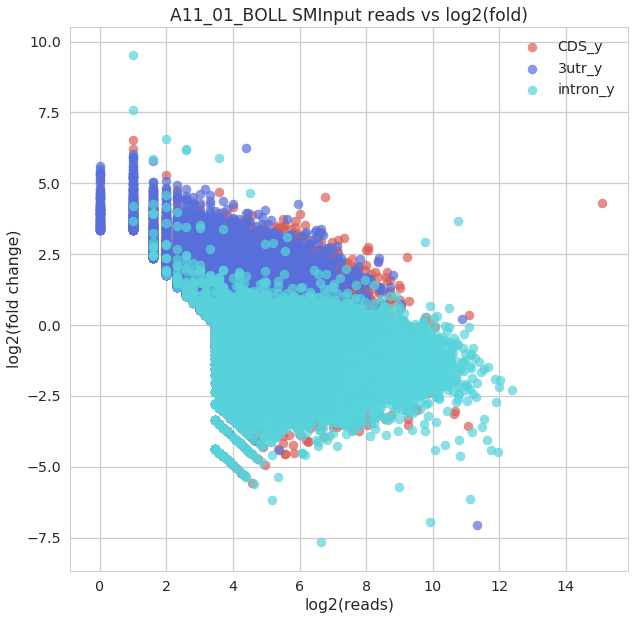

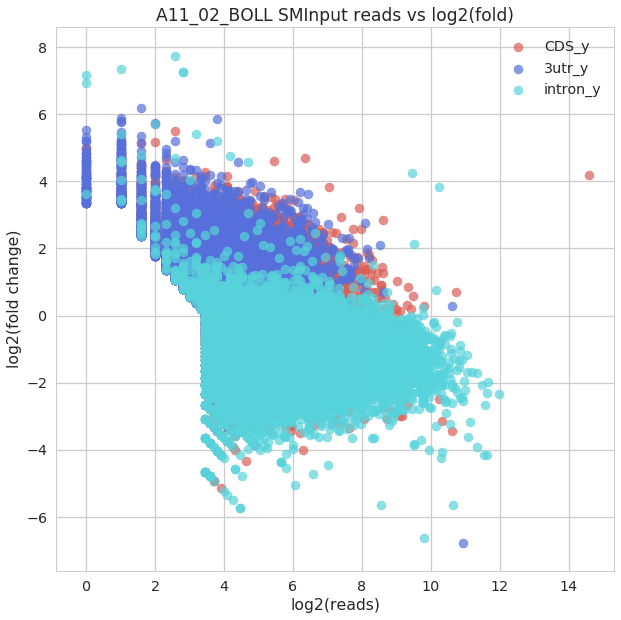

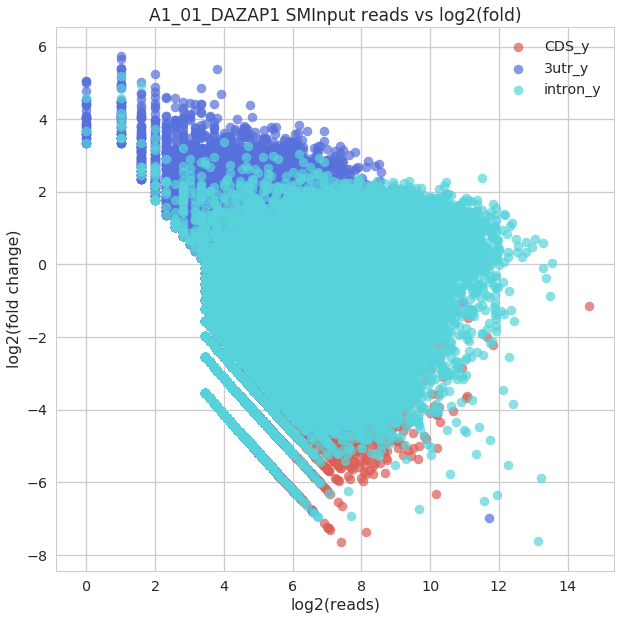

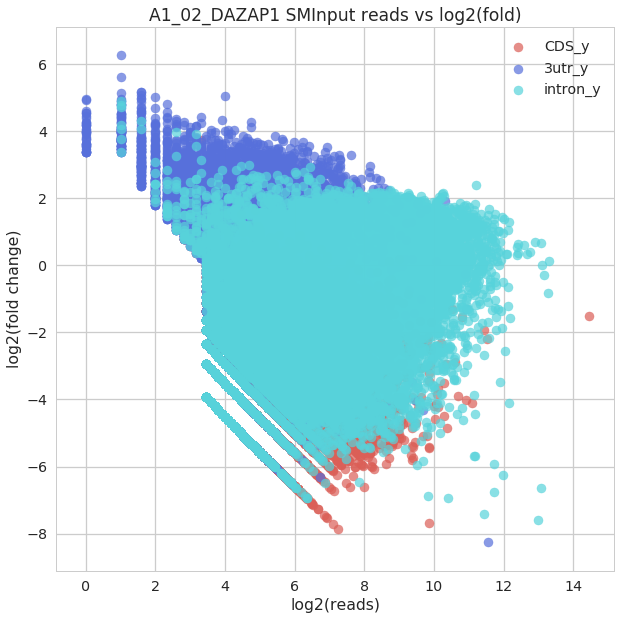

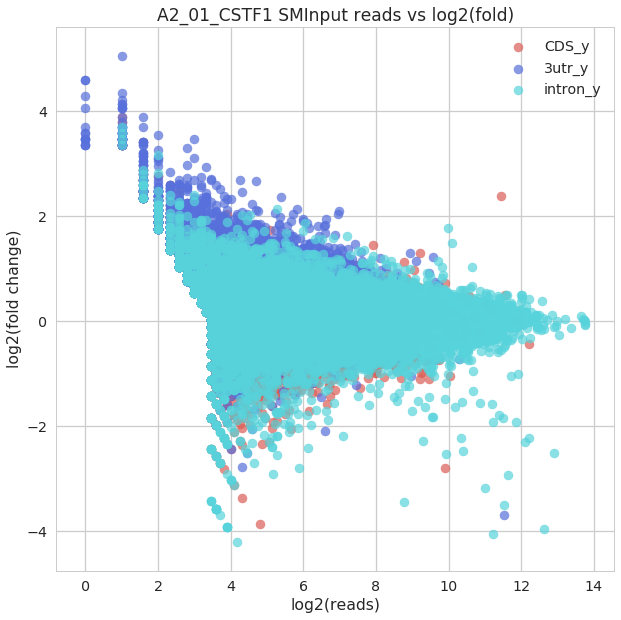

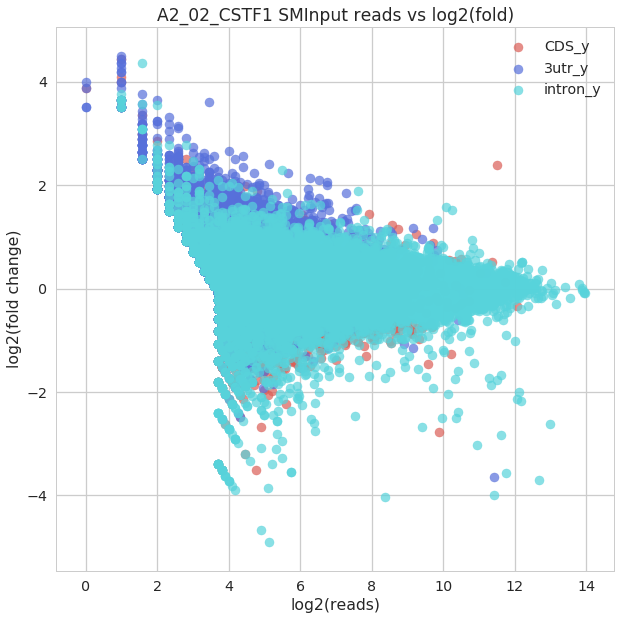

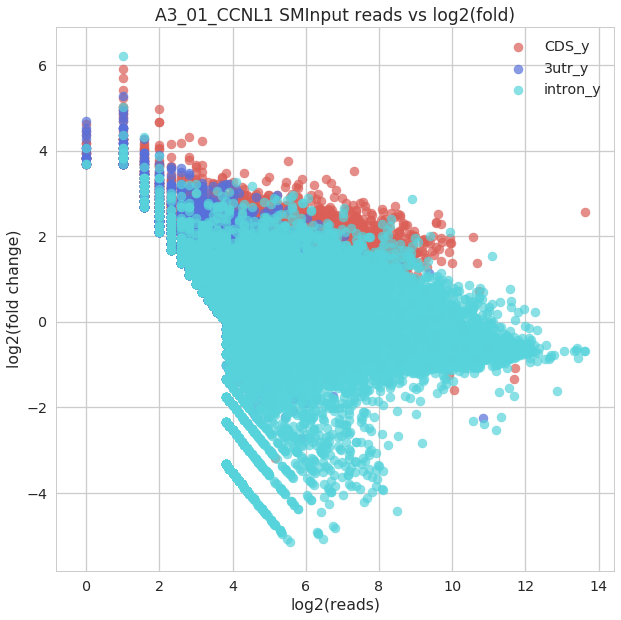

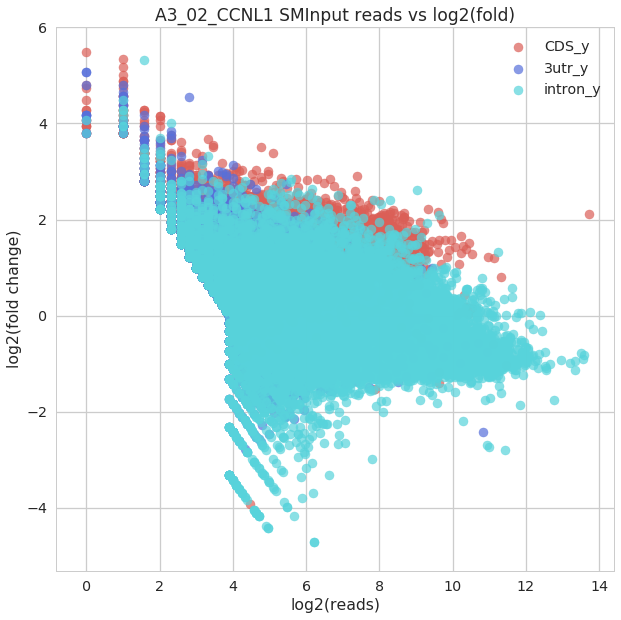

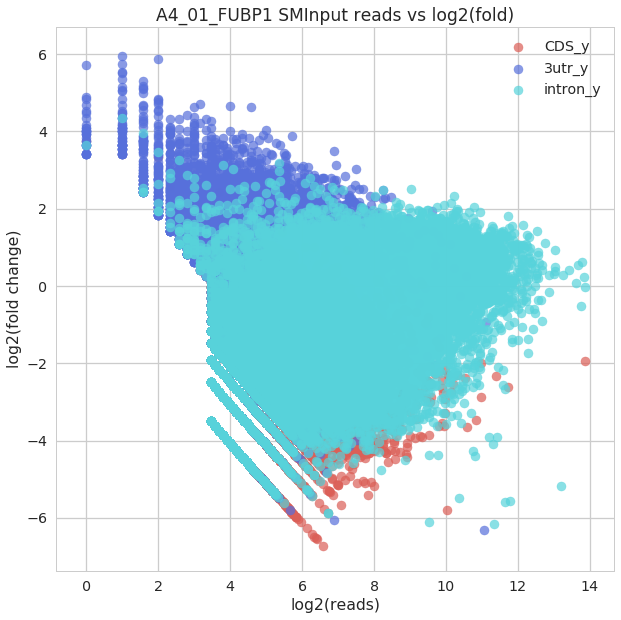

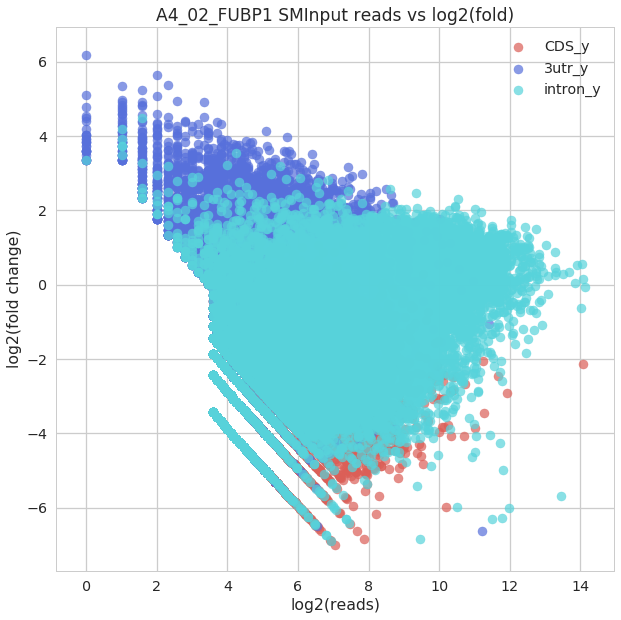

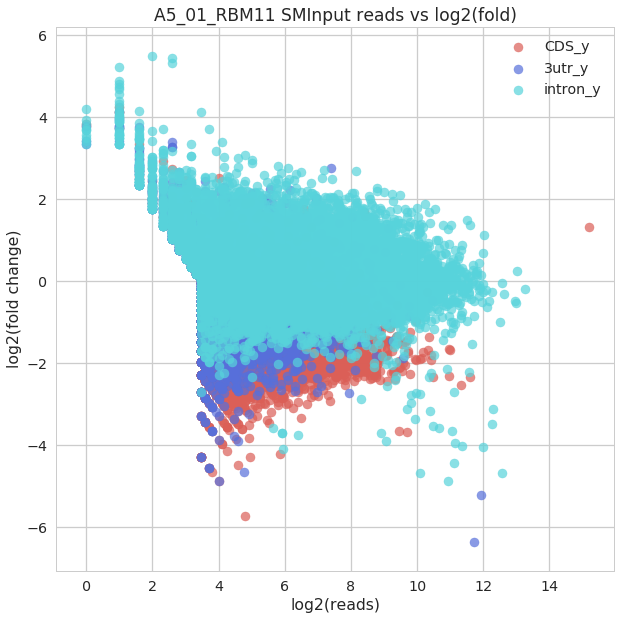

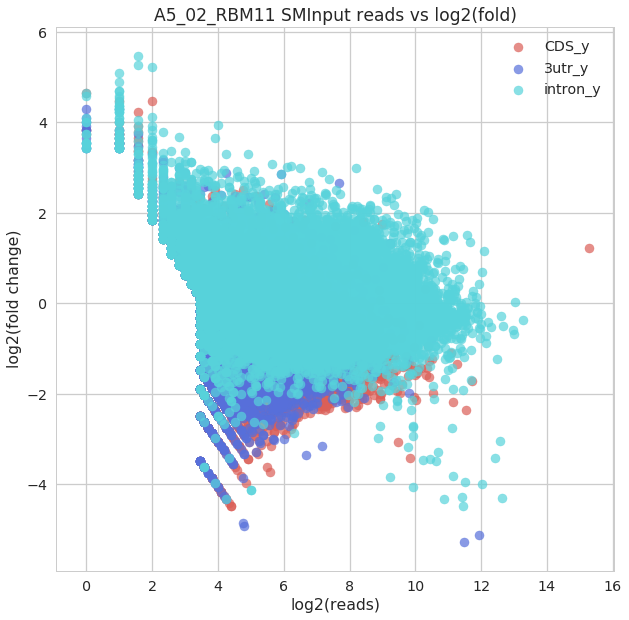

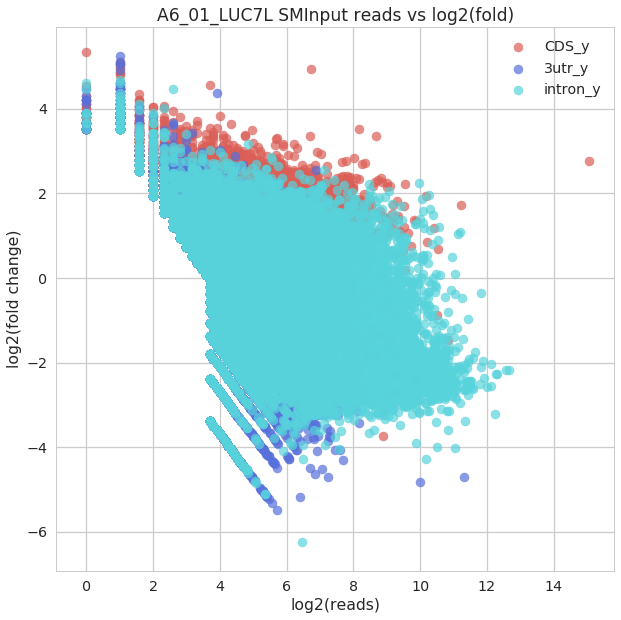

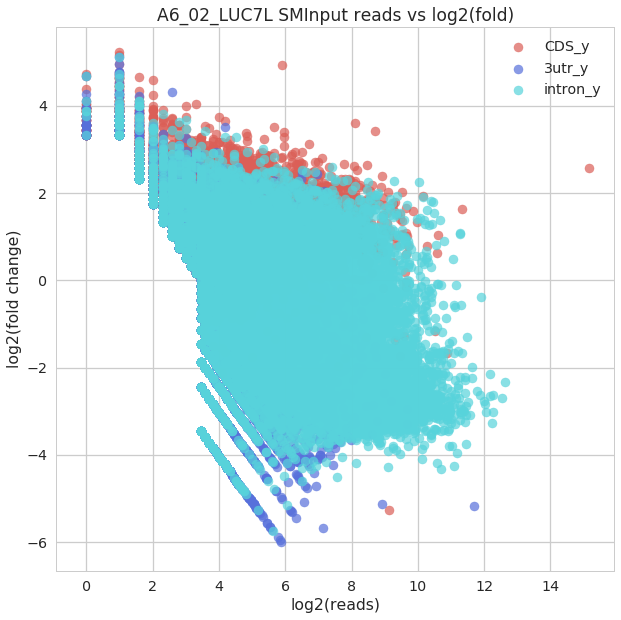

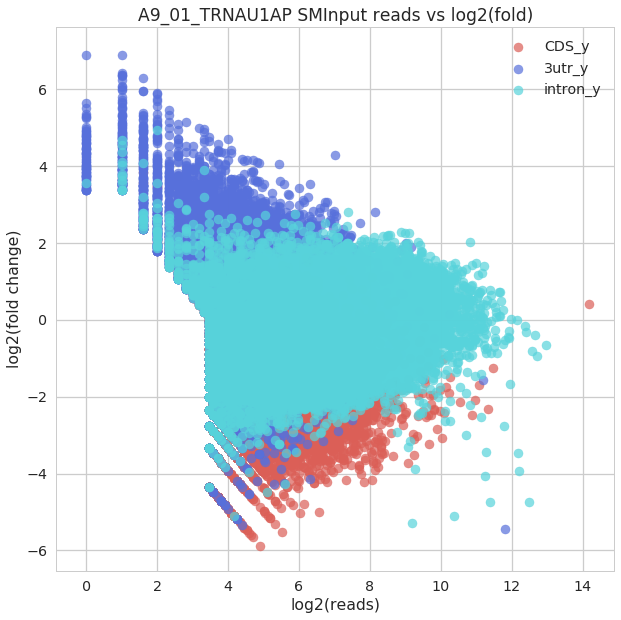

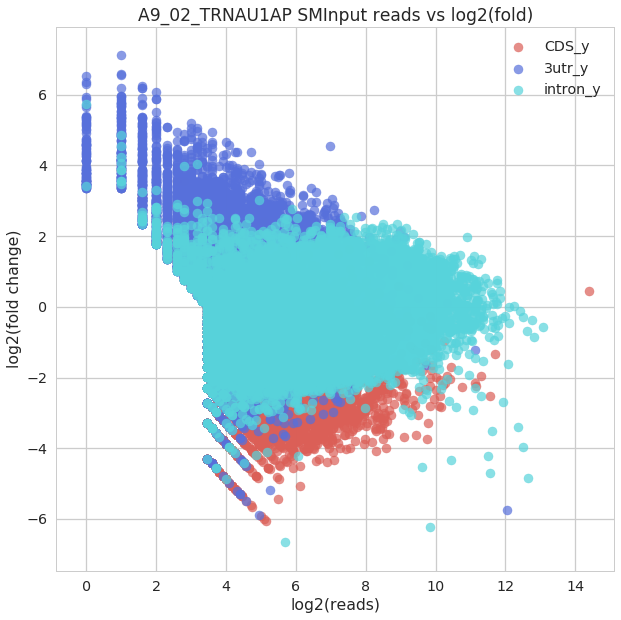

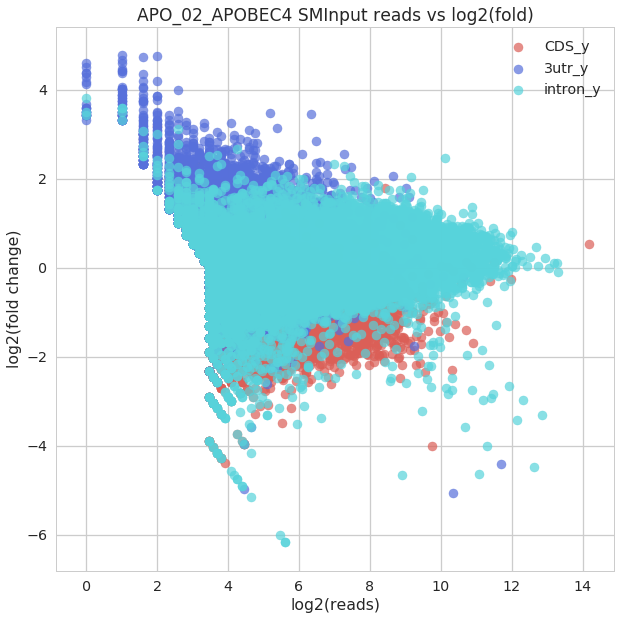

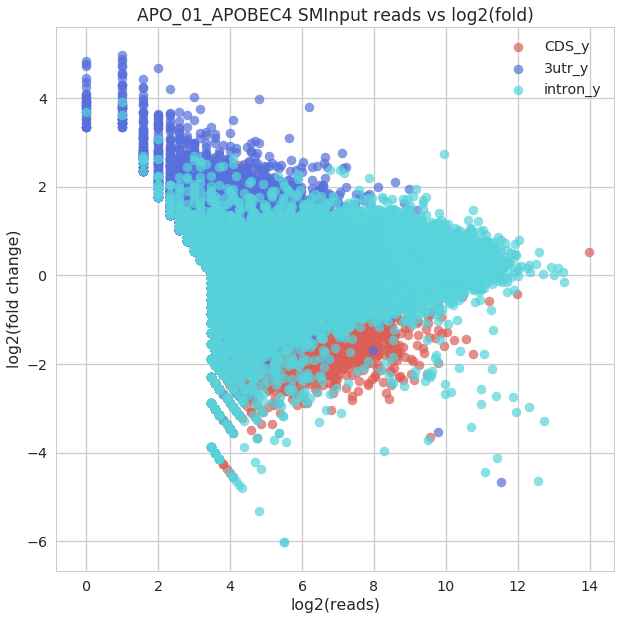

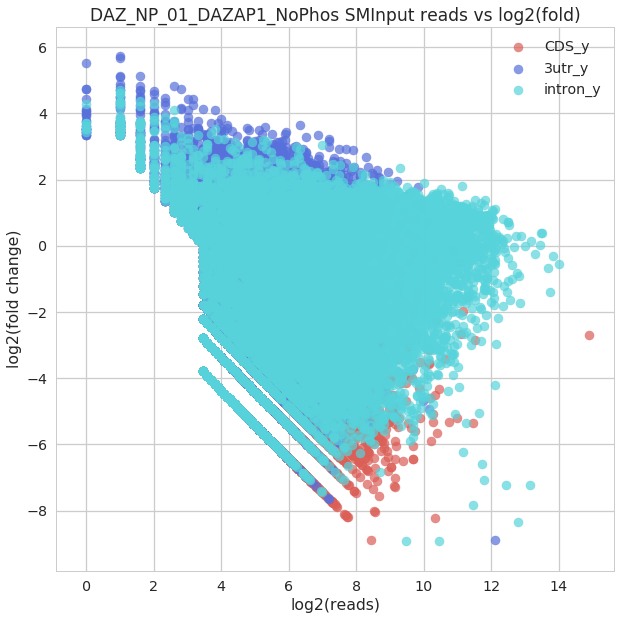

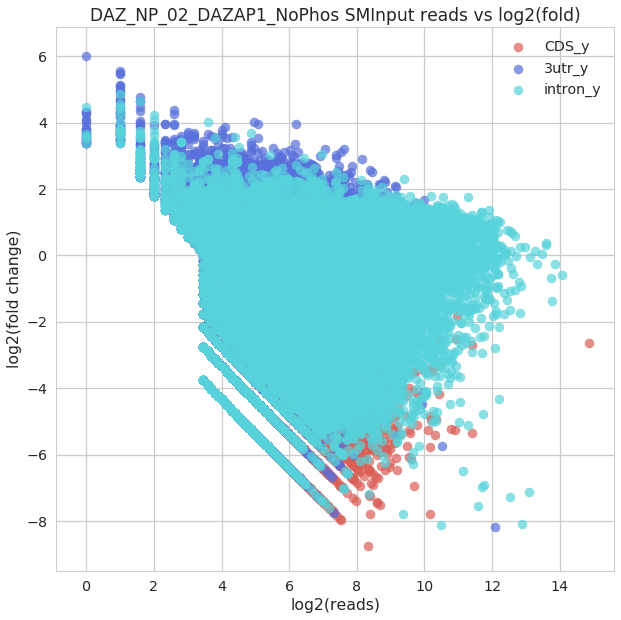

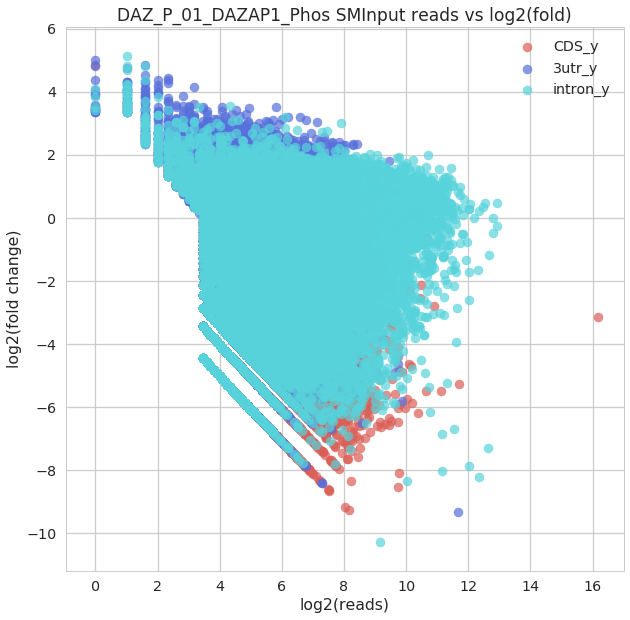

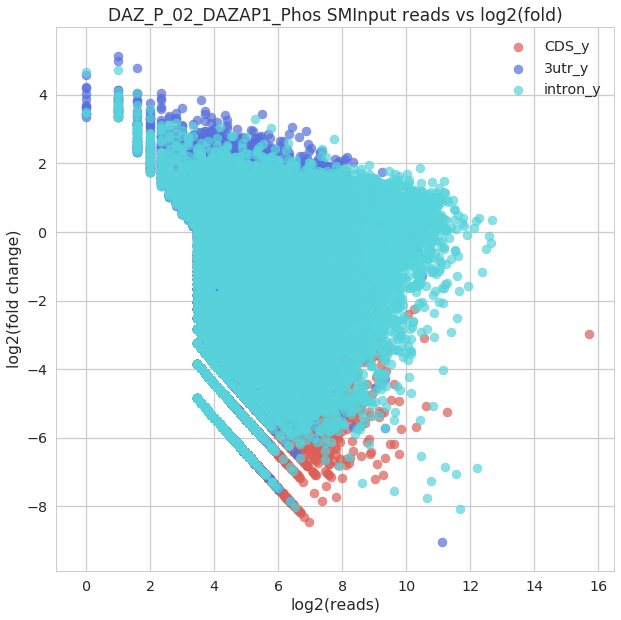

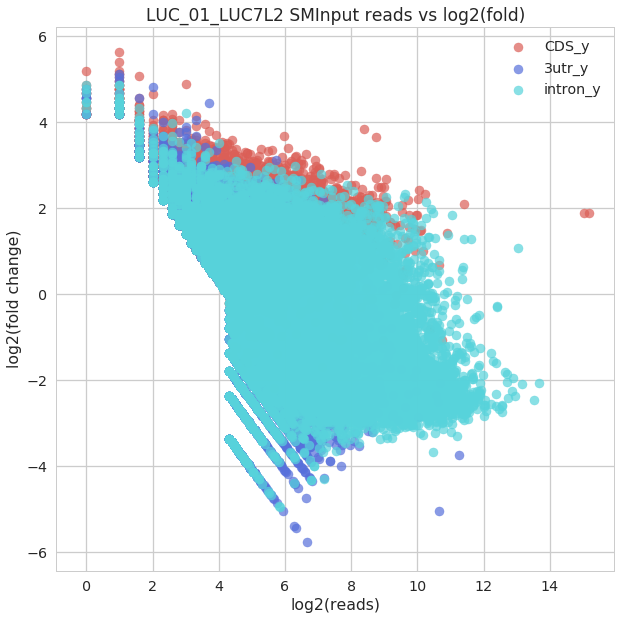

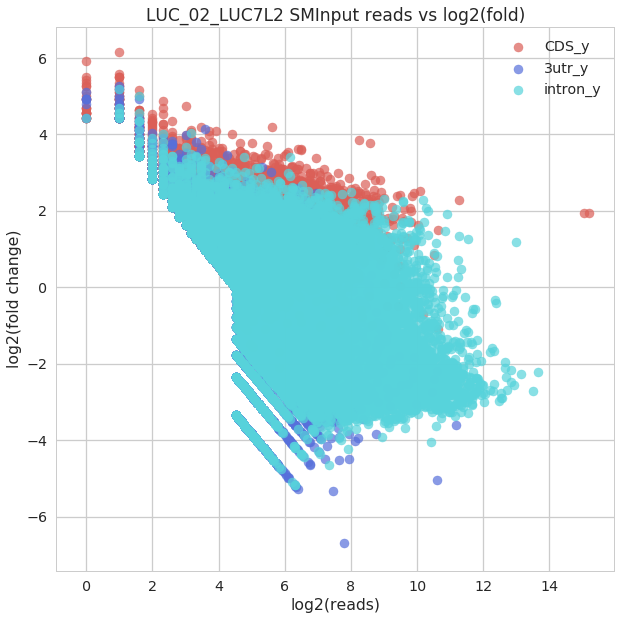

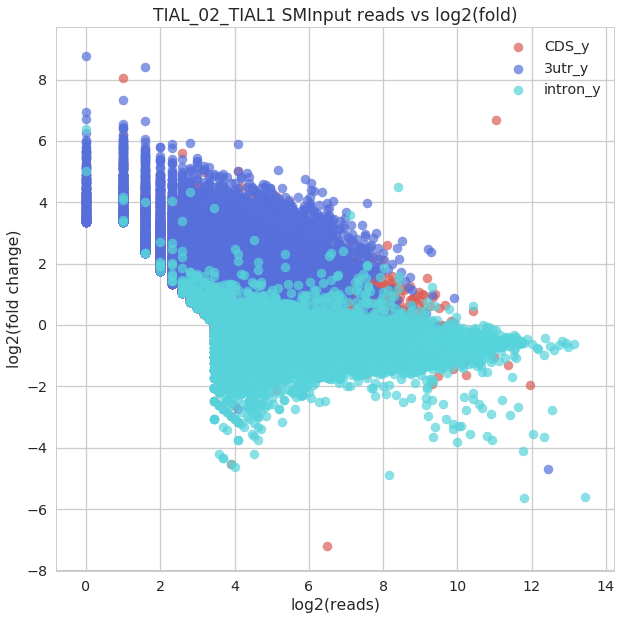

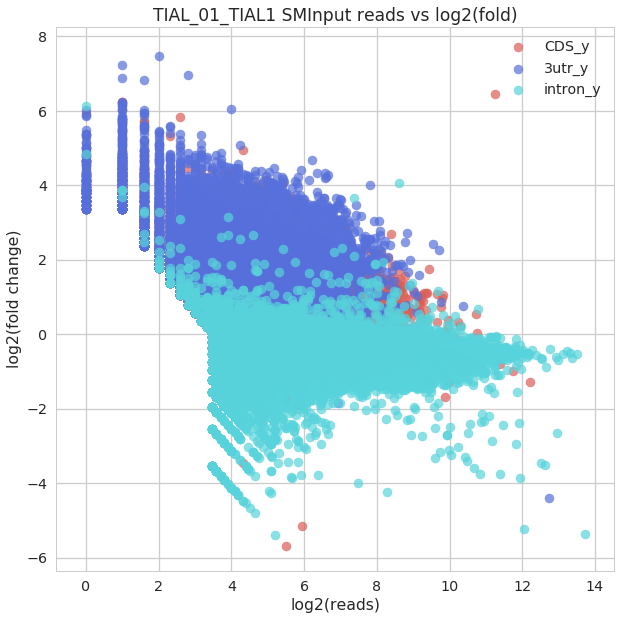

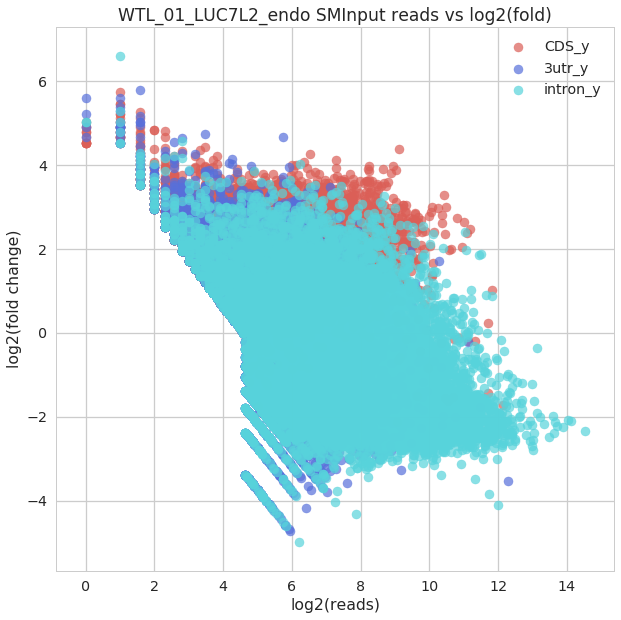

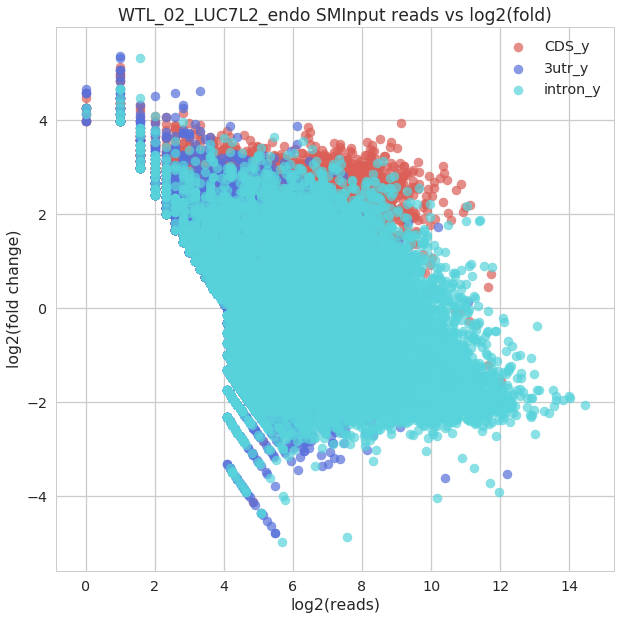

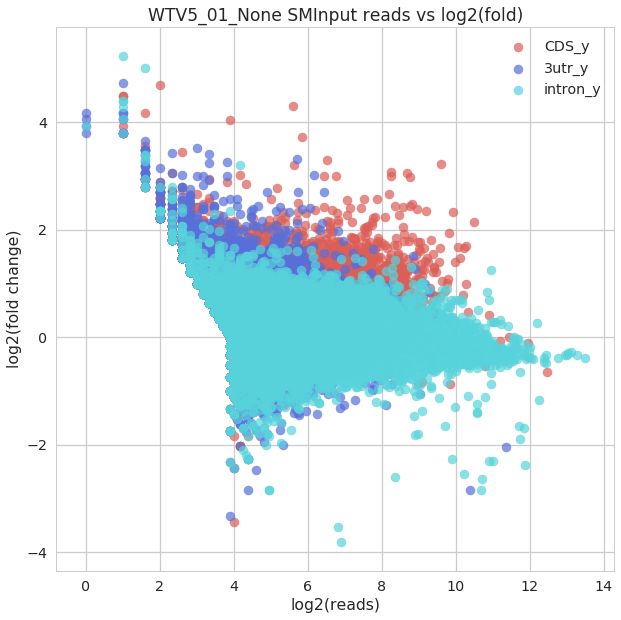

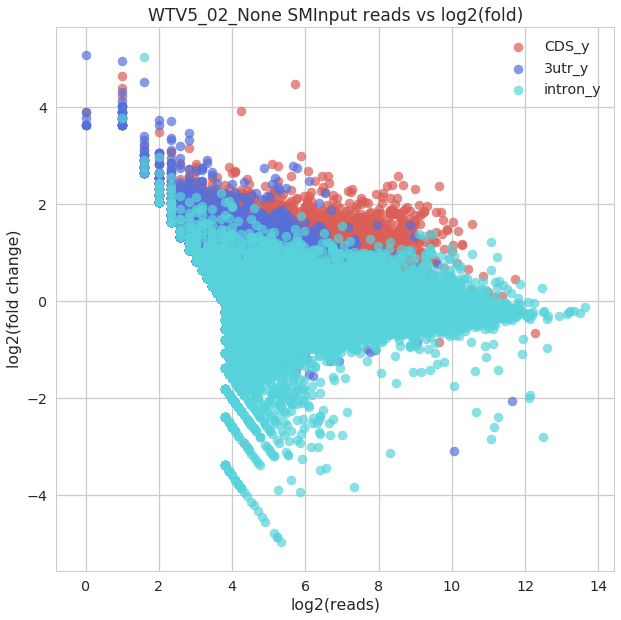

In [8]:
ReadsByLoc_combined_csv_l2fcwithpval_enr = [
    'ENSG','CDS','CDS-pvalue','5utr','5utr-pvalue','3utr','3utr-pvalue',
    '5_and_3_utr','5_and_3_utr-pvalue','intron','intron-pvalue',
    'intergenic','intergenic-pvalue','noncoding_exon','noncoding_exon-pvalue',
    'noncoding_intron','noncoding_intron-pvalue'
]
y = tnrange(manifest_df.shape[0])
for col, row in manifest_df.iterrows():
    
    rep1 = pd.read_table(
        row['input'], 
        index_col=0
    )
    rep2 = pd.read_table(
        row['ip'],
        sep='[\t\|]+',
        engine='python',
        index_col=0,
        skiprows=1,
        names=ReadsByLoc_combined_csv_l2fcwithpval_enr
    )
    x = pd.merge(rep1,rep2,how='inner',left_index=True,right_index=True)
    
    f, ax = plt.subplots(figsize=(10,10))
    ax.scatter(np.log2(x['CDS_x']+1),x['CDS_y'],color=cds,alpha=0.7)
    ax.scatter(np.log2(x['3utr_x']+1),x['3utr_y'],color=utr3,alpha=0.7)
    ax.scatter(np.log2(x['intron_x']+1),x['intron_y'],color=intron,alpha=0.7)
    ax.set_title("{}_{} SMInput reads vs log2(fold)".format(
                row['uID'],
                row['RBP']))
    ax.set_xlabel("log2(reads)")
    ax.set_ylabel("log2(fold change)")
    plt.legend()
    x.columns = [col.replace(
        '_x','_INPUTREADS').replace(
        '_y','_l2_IPFOLDENRICHMENT').replace(
        '5utr|3utr','5utr|3utr_INPUTREADS').replace(
        '5_and_3_utr','5_and_3_utr_l2_IPFOLDENRICHMENT') for col in x.columns]
    x.to_csv(os.path.join(out_dir,"{}_{}.fc_over_input_reads.tsv".format(
                row['uID'],
                row['RBP'])),
            sep='\t')
    f.savefig(os.path.join(img_dir,"{}_{}.fc_over_input_reads.svg".format(
                row['uID'],
                row['RBP'])))
    y.update(1)

# Figure 4c - Pearson correlation plots for reps of all RBPs

In [9]:
def trim_pvalue(df,region,p=0):
    """
    Assume the format of the dataframe is exactly described 
    by the read_rep() function.
    Assume it's a log transformation of p...
    """
    return df# df[df["{}-pvalue".format(region)]>=p]

def get_p2corr(r1,r2,region):
    """
    Returns the correlation (basically plot_jointplot without the plot)
    """
    common = set(r1.index).intersection(set(r2.index)) # not an index but a Set
    r1 = r1.ix[common][region]
    r2 = r2.ix[common][region]
    return pow(r1.corr(r2),2)

def plot_jointplot(rep1,rep2,out,title,region,p):
    """
    Plots a regplot and returns the r^2 correlation value. 
    We don't use this but this builds the individual plots and returns 
    individual correlation values (the same values used to make the heatmap)
    """
    f, ax = plt.subplots()
    r1 = trim_pvalue(rep1,region,p)
    r2 = trim_pvalue(rep2,region,p)
    common = set(r1.index).intersection(set(r2.index)) # not an index but a Set
    r1 = r1.ix[common][region]
    r2 = r2.ix[common][region]
    ax = sns.regplot(r1,r2)
    ax.set_title(title)
    f.savefig(out)
    return pow(r1.corr(r2),2)

In [10]:
cds = {}
utr5 = {}
utr3 = {}
intron = {}
nc_e = {}
nc_i = {}

readsbylocs = glob.glob(os.path.join(wd,'*ReadsByLoc_combined.csv.l2fcwithpval_enr.csv'))

reps = {}

# append replicate information
for f in readsbylocs:
    name = os.path.basename(f)
    rbp_norep = name.replace('_01','').replace('_02','')
    rbp_norep_nice = rbp_norep.replace('_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv',"")
    if not rbp_norep_nice in reps.keys():
        reps[rbp_norep_nice] = [name]
    else:
        reps[rbp_norep_nice].append(name)

# so the rep1 is first
for key in reps.keys():
    reps[key] = sorted(reps[key])
reps

{'A11_BOLL': ['A11_01_BOLL_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv',
  'A11_02_BOLL_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv'],
 'A1_DAZAP1': ['A1_01_DAZAP1_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv',
  'A1_02_DAZAP1_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv'],
 'A2_CSTF1': ['A2_01_CSTF1_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv',
  'A2_02_CSTF1_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv'],
 'A3_CCNL1': ['A3_01_CCNL1_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv',
  'A3_02_CCNL1_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv'],
 'A4_FUBP1': ['A4_01_FUBP1_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv',
  'A4_02_FUBP1_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv'],
 'A5_RBM11': ['A5_01_RBM11_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv',
  'A5_02_RBM11_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv'],
 'A6_LUC7L': ['A6_01_LUC7L_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv',
  'A6_02_LUC7L_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv'],
 'A9_TRNAU1AP': ['A9_01_TRNAU1AP_Reads

In [11]:
# for each rbp (key), build the dictionary of correlation values for each region (cds, utr5, etc.)

for rbp in reps.keys():
    if(len(reps[rbp])==2):
        regions = {
            'CDS':cds,'5utr':utr5,'3utr':utr3,'intron':intron,
            'noncoding_exon':nc_e,'noncoding_intron':nc_i
        }
        for region, dic in regions.iteritems():
            rep1 = pd.read_table(
                os.path.join(wd,reps[rbp][0]),sep='[\t\|]+',engine='python',
                index_col=0,skiprows=1,names=ReadsByLoc_combined_csv_l2fcwithpval_enr
            )
            rep2 = pd.read_table(
                os.path.join(wd,reps[rbp][1]),sep='[\t\|]+',engine='python',
                index_col=0,skiprows=1,names=ReadsByLoc_combined_csv_l2fcwithpval_enr
            )
            dic[rbp] = get_p2corr(rep1,rep2,region)
    else:
        print("Warning: {} does not have 2 reps.".format(rbp))

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


In [12]:
# merge all correlation values together
merged = pd.DataFrame(index=cds.keys()) # cds.keys = all RBPs, we're just using cds.keys as an index
for region, corr_dict in regions.iteritems():
    df = pd.DataFrame(corr_dict,index=[region]).T
    merged = pd.merge(merged,df,how='left',left_index=True,right_index=True)
merged

noncoding_exon      3utr      5utr    intron  \
A3_CCNL1                    0.692557  0.539924  0.257020  0.758963   
WTL_LUC7L2_endo             0.872608  0.813384  0.449135  0.905116   
A4_FUBP1                    0.847026  0.866420  0.680543  0.887125   
A2_CSTF1                    0.689264  0.361571  0.249504  0.498315   
DAZ_P_DAZAP1_Phos           0.913863  0.919797  0.771180  0.935934   
A9_TRNAU1AP                 0.881831  0.834382  0.701312  0.861195   
A1_DAZAP1                   0.874609  0.895769  0.677845  0.916059   
A6_LUC7L                    0.848355  0.779166  0.318246  0.880334   
DAZ_NP_DAZAP1_NoPhos        0.896016  0.914092  0.724968  0.929518   
A11_BOLL                    0.921718  0.655147  0.733894  0.784505   
APO_APOBEC4                 0.801844  0.620489  0.544513  0.708081   
TIAL_TIAL1                  0.839658  0.673043  0.570742  0.537910   
A5_RBM11                    0.830460  0.551725  0.585041  0.773144   
LUC_LUC7L2                  0.870370  0.834446  0.458581  0.897318   
WTV5_None                   0.637202  0.319985  0.258516  0.224672   

                      noncoding_intron       CDS  
A3_CCNL1                      0.608740  0.200867  
WTL_LUC7L2_endo               0.798817  0.502085  
A4_FUBP1                      0.788642  0.663763  
A2_CSTF1                      0.452570  0.261051  
DAZ_P_DAZAP1_Phos             0.894687  0.805303  
A9_TRNAU1AP                   0.770993  0.768271  
A1_DAZAP1                     0.850929  0.727425  
A6_LUC7L                      0.810450  0.344404  
DAZ_NP_DAZAP1_NoPhos          0.891740  0.772701  
A11_BOLL                      0.801833  0.798636  
APO_APOBEC4                   0.607056  0.468211  
TIAL_TIAL1                    0.624271  0.694631  
A5_RBM11                      0.687278  0.464980  
LUC_LUC7L2                    0.840830  0.498279  
WTV5_None                     0.220192  0.185243

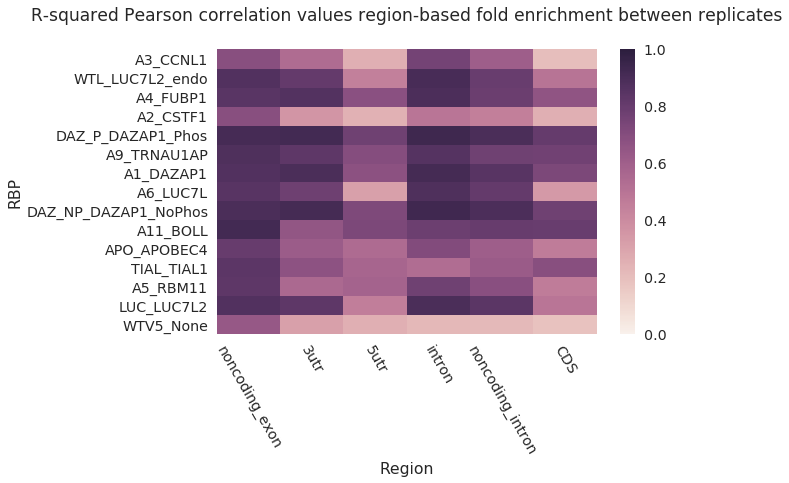

In [13]:
sns.heatmap(merged,vmin=0,vmax=1)
plt.xticks(rotation=300)
plt.title("R-squared Pearson correlation values region-based fold enrichment between replicates",y=1.08)
plt.xlabel("Region")
plt.ylabel("RBP")
plt.tight_layout()
plt.savefig(os.path.join(img_dir,'rsquared_pearson_correlation_heatmap.svg'))

# Figure 4d - Peak distribution across regions

In [14]:
def return_region(row):
    """
    Given a row of a inputnormed bedfile, return region
    """
    try:
        if row['annotation']=='intergenic':
            return 'intergenic'
        region = row['annotation'].split('|')[0]

        return region
    except Exception as e:
        print(e)
        print(row)
def inc_rep(row):
    """
    Reformats naming scheme to something standard.
    This is to make it easier to interpret the charts, 
    which are based on inputnorm.bed naming conventions.
    """
    rep = row['uID'].split('_')[-1]
    return "{}_{}".format(row['RBP'],rep)

manifest_df['new_name'] = manifest_df.apply(inc_rep,axis=1)
acc2name = dict(zip(manifest_df.uID, manifest_df.new_name))
acc2name['204_01'] ='RBFOX2_01'
acc2name['204_02'] ='RBFOX2_02'
acc2name

{'204_01': 'RBFOX2_01',
 '204_02': 'RBFOX2_02',
 'A11_01': 'BOLL_01',
 'A11_02': 'BOLL_02',
 'A1_01': 'DAZAP1_01',
 'A1_02': 'DAZAP1_02',
 'A2_01': 'CSTF1_01',
 'A2_02': 'CSTF1_02',
 'A3_01': 'CCNL1_01',
 'A3_02': 'CCNL1_02',
 'A4_01': 'FUBP1_01',
 'A4_02': 'FUBP1_02',
 'A5_01': 'RBM11_01',
 'A5_02': 'RBM11_02',
 'A6_01': 'LUC7L_01',
 'A6_02': 'LUC7L_02',
 'A9_01': 'TRNAU1AP_01',
 'A9_02': 'TRNAU1AP_02',
 'APO_01': 'APOBEC4_01',
 'APO_02': 'APOBEC4_02',
 'DAZ_NP_01': 'DAZAP1_NoPhos_01',
 'DAZ_NP_02': 'DAZAP1_NoPhos_02',
 'DAZ_P_01': 'DAZAP1_Phos_01',
 'DAZ_P_02': 'DAZAP1_Phos_02',
 'LUC_01': 'LUC7L2_01',
 'LUC_02': 'LUC7L2_02',
 'TIAL_01': 'TIAL1_01',
 'TIAL_02': 'TIAL1_02',
 'WTL_01': 'LUC7L2_endo_01',
 'WTL_02': 'LUC7L2_endo_02',
 'WTV5_01': 'None_01',
 'WTV5_02': 'None_02'}

In [15]:
suffix = '.peaks.l2inputnormnew.bed.compressed.bed.annotated'
progress = tnrange(len(glob.glob(os.path.join(original_input_norm_dir,'*.annotated'))))

def get_counts(wd):
    """
    Returns the number of peak counts for all regions annotated by eric's pipeline.
    
    Parameters
    ----------
    wd : string
        directory where the input_norm output is kept (where to look for .annotated files)
    """
    samples = {}
    for f in glob.glob(os.path.join(wd,'*.annotated')):
        df = pd.read_table(f,names=annotated_bedhead)
        df = df[(df['pv'] >= PVALUE_CUTOFF) & (df['fc'] >= FOLD_CHANGE_CUTOFF)]
        basename = f.replace(wd+'/','').replace(suffix,'')
        basename = os.path.basename(basename)
        basename = re.sub(r'\.basedon_\w+','',basename)
        rep = basename.split('_')[-1]
        basename = basename.replace("_01_01","_01").replace("_02_01","_02")
        basename = acc2name[basename]

        samples[basename] = {}
        df['region'] = df.apply(return_region,axis=1)
        for key,value in df['region'].value_counts().iteritems():
            samples[basename][key] = value
        for region in regions:
            if region not in samples[basename]:
                samples[basename][region] = 0
        progress.update(1)
    return samples

# take out intergenic and 3_and_5prime annotations per discussion 8-25-2016
samples = get_counts(original_input_norm_dir)
df = pd.DataFrame(samples)
df.drop('5utr_and_3utr',inplace=True)
df.drop('intergenic',inplace=True)
df

APOBEC4_01  APOBEC4_02  BOLL_01  BOLL_02  CCNL1_01  \
3utr                   510.0         453     2276   1736.0     114.0   
5utr                    33.0          30      224    340.0     194.0   
CDS                     35.0          21     2856   2040.0    2491.0   
intron                1226.0        1100      303    296.0     321.0   
noncoding_exon          61.0          43      103    111.0      57.0   
noncoding_intron        71.0          56       75     78.0      15.0   

                  CCNL1_02  CSTF1_01  CSTF1_02  DAZAP1_01  DAZAP1_02  \
3utr                  59.0     117.0     106.0       5381       5757   
5utr                 122.0      37.0      56.0         77         94   
CDS                 1045.0      65.0      53.0        156        163   
intron               145.0     392.0     441.0      13813      13534   
noncoding_exon        31.0      21.0      12.0        234        238   
noncoding_intron       7.0      12.0      23.0        714        705   

                     ...       LUC7L_01  LUC7L_02  None_01  None_02  RBM11_01  \
3utr                 ...           45.0        24     42.0     42.0      47.0   
5utr                 ...          261.0       564     28.0     29.0     208.0   
CDS                  ...         1783.0      1694    567.0    570.0      37.0   
intron               ...          182.0       264     34.0     41.0    1089.0   
noncoding_exon       ...           37.0        53     18.0     15.0      52.0   
noncoding_intron     ...           23.0        16      8.0      6.0     128.0   

                  RBM11_02  TIAL1_01  TIAL1_02  TRNAU1AP_01  TRNAU1AP_02  
3utr                  51.0    7423.0    7585.0         4309         4869  
5utr                 346.0     160.0     154.0           69           81  
CDS                   88.0    1868.0    1709.0          326          378  
intron              1677.0     119.0     122.0         3600         3997  
noncoding_exon        62.0     117.0     139.0          124          133  
noncoding_intron     156.0      37.0      34.0          113          123  

[6 rows x 30 columns]

In [16]:
df.sum()

APOBEC4_01           1936.0
APOBEC4_02           1703.0
BOLL_01              5837.0
BOLL_02              4601.0
CCNL1_01             3192.0
CCNL1_02             1409.0
CSTF1_01              644.0
CSTF1_02              691.0
DAZAP1_01           20375.0
DAZAP1_02           20491.0
DAZAP1_NoPhos_01    11686.0
DAZAP1_NoPhos_02    11800.0
DAZAP1_Phos_01       5221.0
DAZAP1_Phos_02       2734.0
FUBP1_01            32734.0
FUBP1_02            41146.0
LUC7L2_01            4841.0
LUC7L2_02            5945.0
LUC7L2_endo_01      13233.0
LUC7L2_endo_02      10401.0
LUC7L_01             2331.0
LUC7L_02             2615.0
None_01               697.0
None_02               703.0
RBM11_01             1561.0
RBM11_02             2380.0
TIAL1_01             9724.0
TIAL1_02             9743.0
TRNAU1AP_01          8541.0
TRNAU1AP_02          9581.0
dtype: float64

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


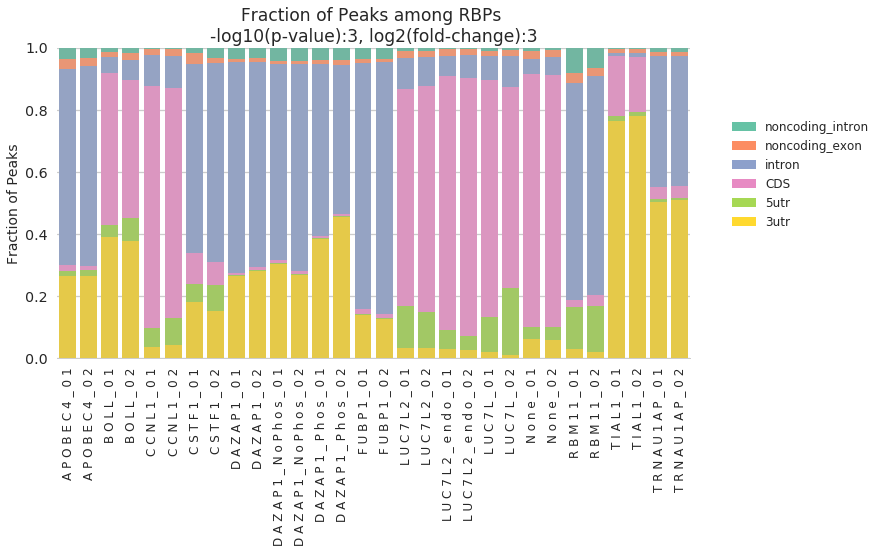

In [17]:
dfdiv = df/df.sum()
cumsum_events = dfdiv.cumsum()

num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "total_fractional_composition_all_samples_no3and5p-nointergenic.svg"), figsize=(10, 8)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    
    legend_builder = []
    legend_labels = []
    for splice_type, color in izip(reversed(cumsum_events.index), sns.color_palette("Set2", len(cumsum_events.index))):
        names = np.array([" ".join(item) for item in cumsum_events.columns])

        sns.barplot(names, 
                    y=cumsum_events.ix[splice_type], color=color, ax=ax)
        
        legend_builder.append(plt.Rectangle((0,0),.25,.25, fc=color, edgecolor = 'none'))
        legend_labels.append(splice_type)

    sns.despine(ax=ax, left=True)
    
    ax.set_ylim(0,1)

    l = ax.legend(legend_builder, 
                  legend_labels, loc=1, ncol = 1, 
                  prop={'size':12}, 
                  bbox_to_anchor=(1.3, 0.8))
    l.draw_frame(False)
    [tick.set_rotation(90) for tick in ax.get_xticklabels()]
    
    ax.set_ylabel("Fraction of Peaks", fontsize=14)
    [tick.set_fontsize(12) for tick in ax.get_xticklabels()]
    ax.set_title("Fraction of Peaks among RBPs \n-log10(p-value):{}, log2(fold-change):{}".format(
        PVALUE_CUTOFF, FOLD_CHANGE_CUTOFF))

# Figure 4e/f - Motif Z-scores
- all data generated from clip_analysis.py script
- all data exported into .pickle files

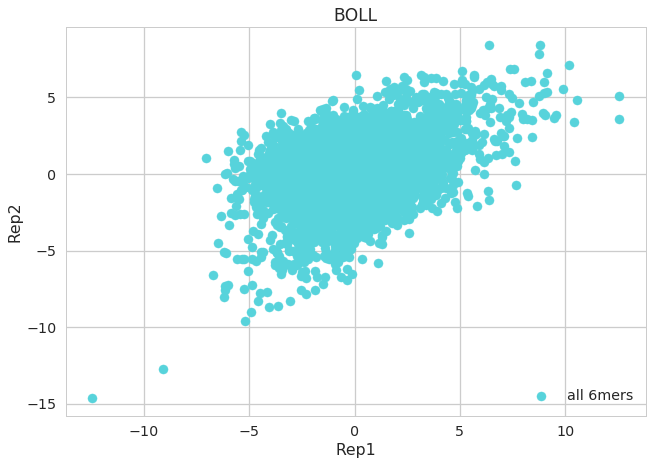

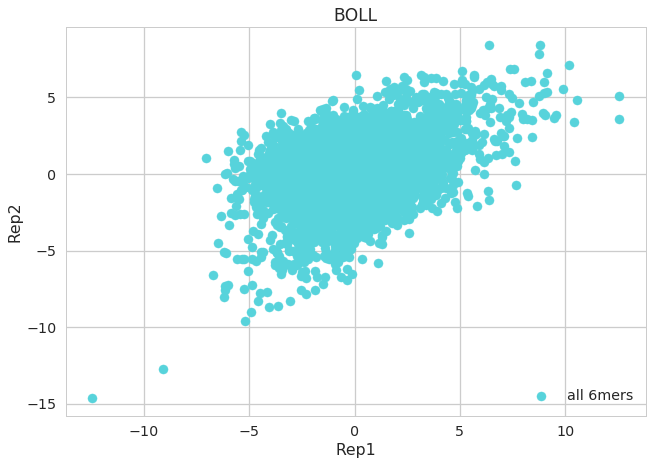

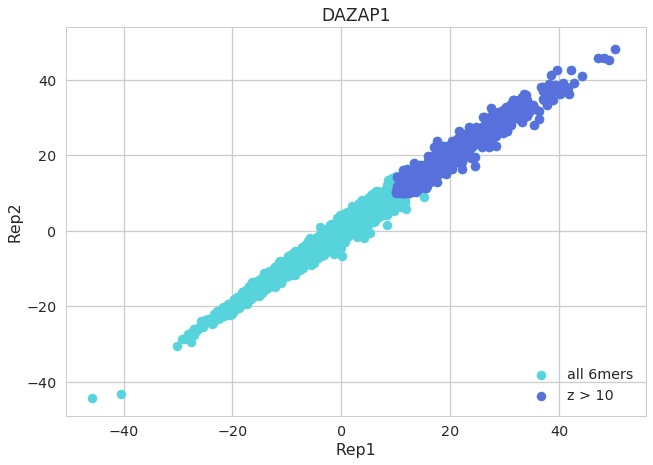

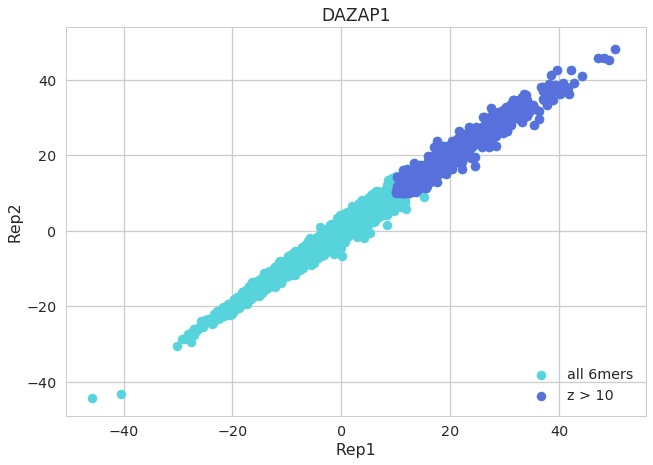

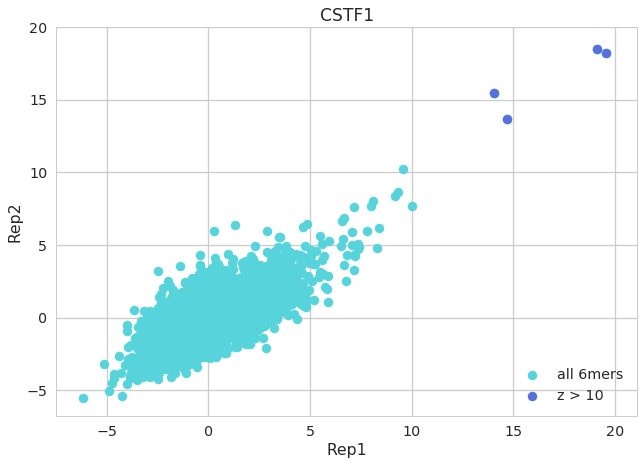

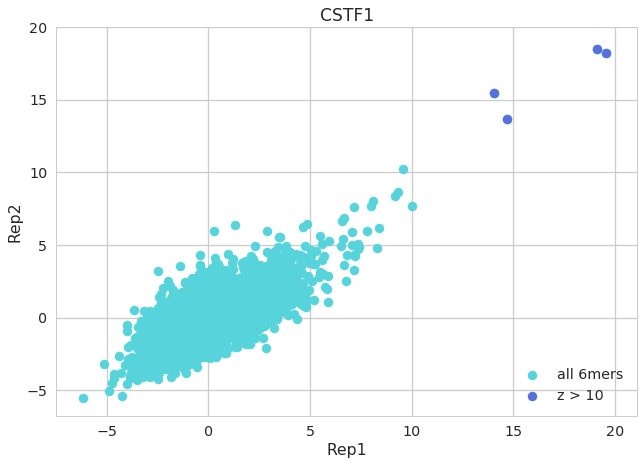

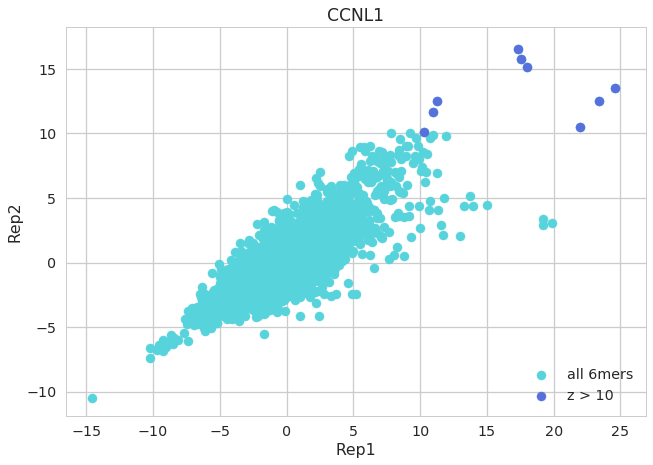

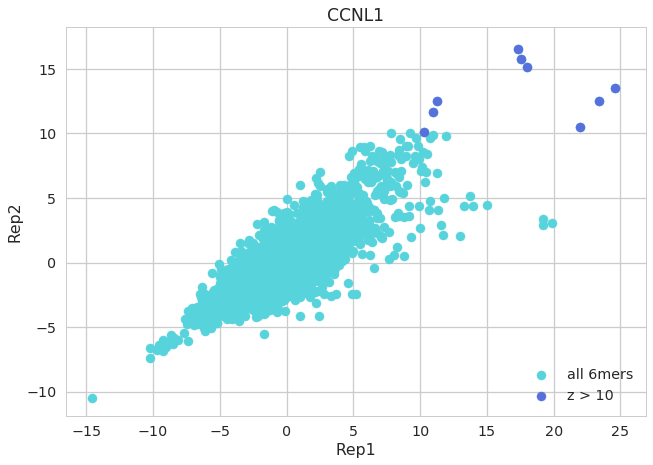

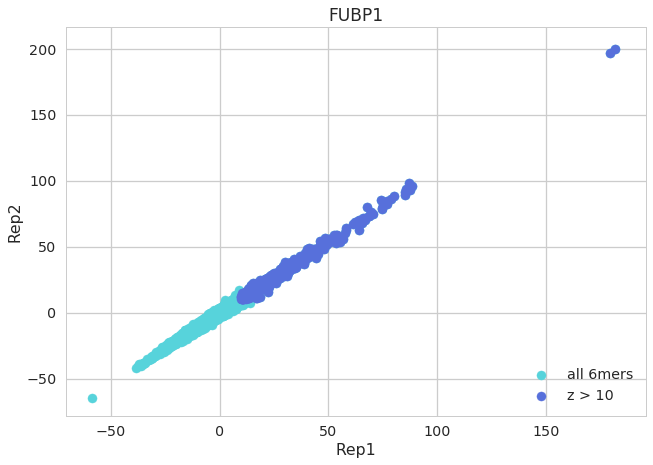

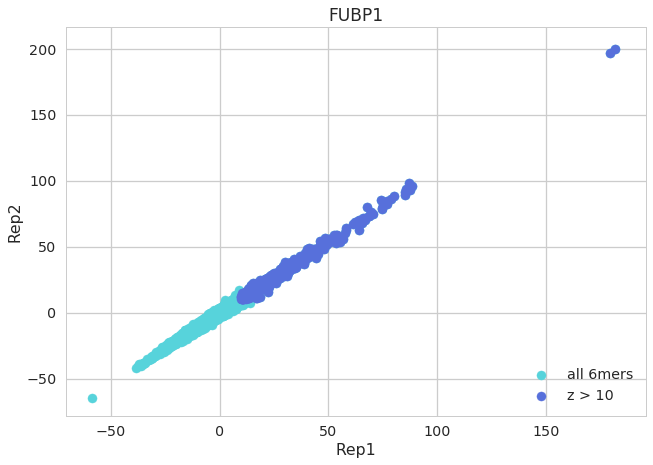

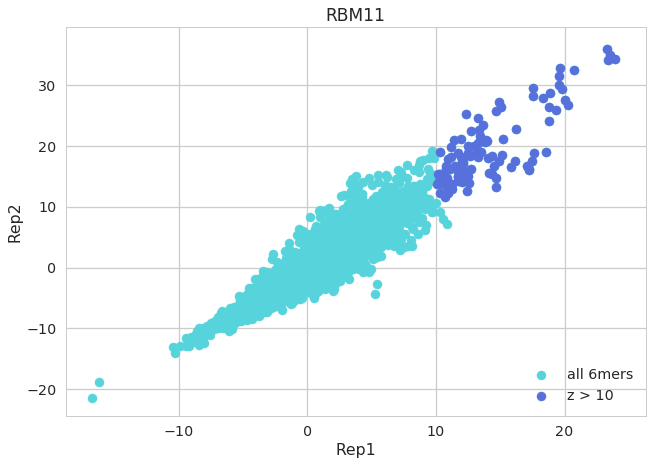

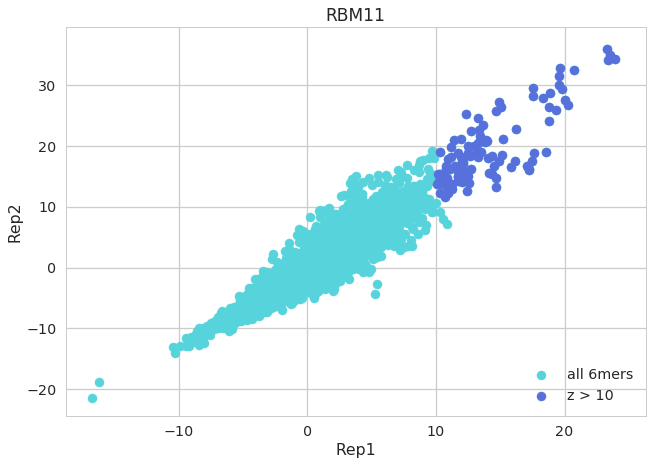

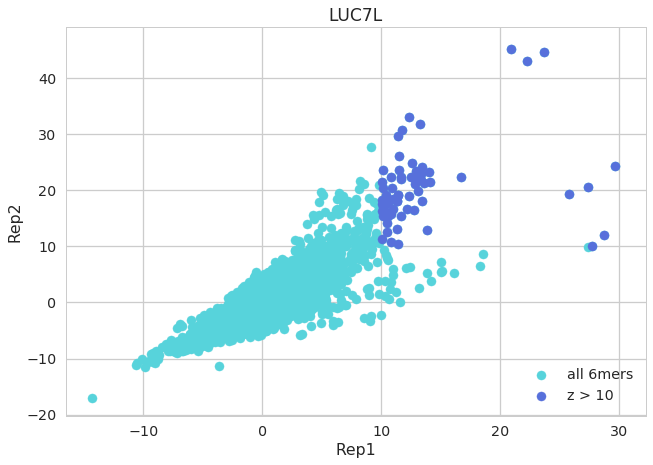

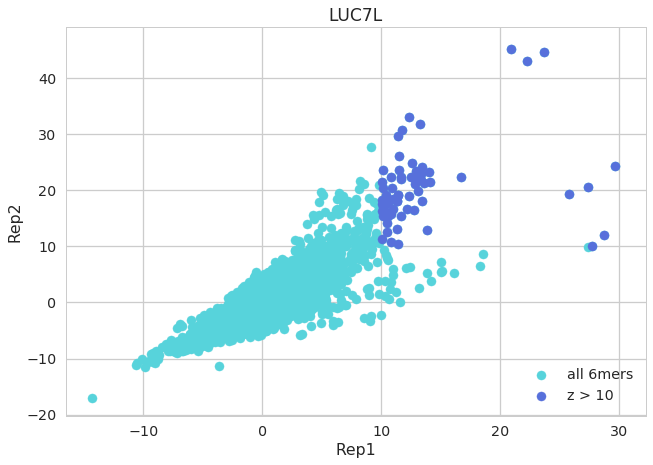

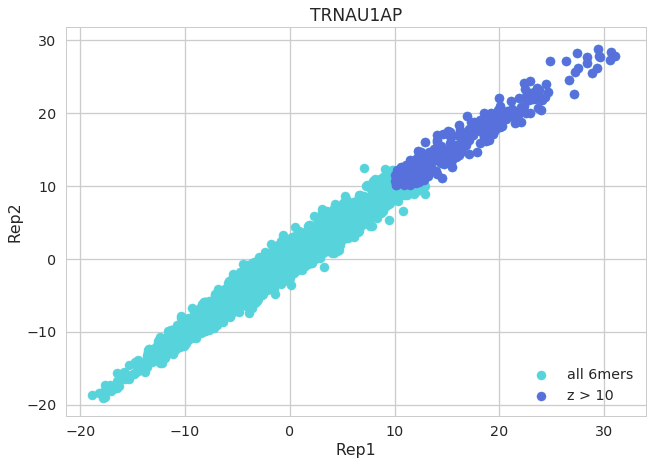

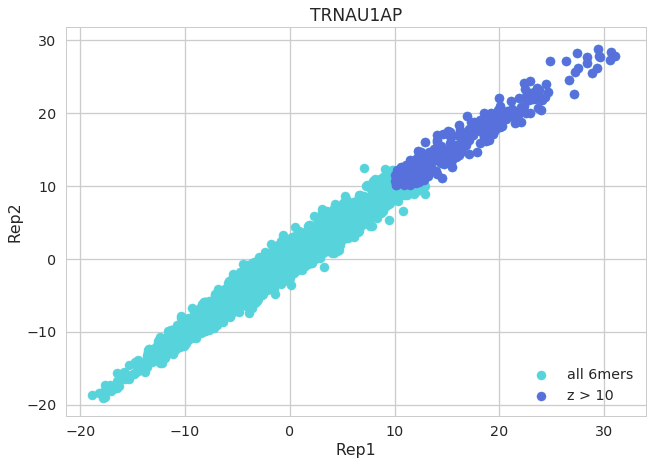

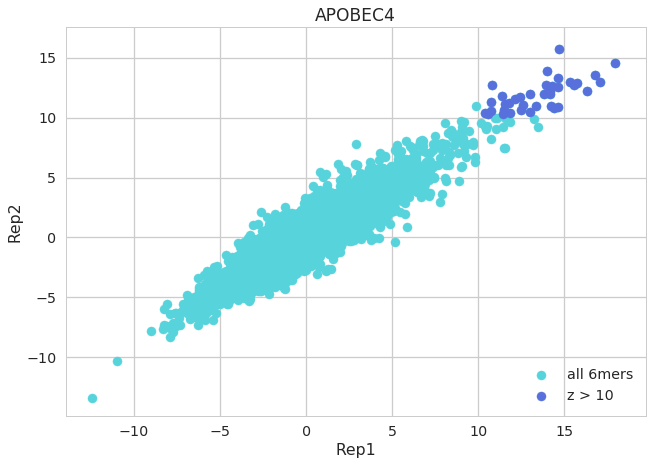

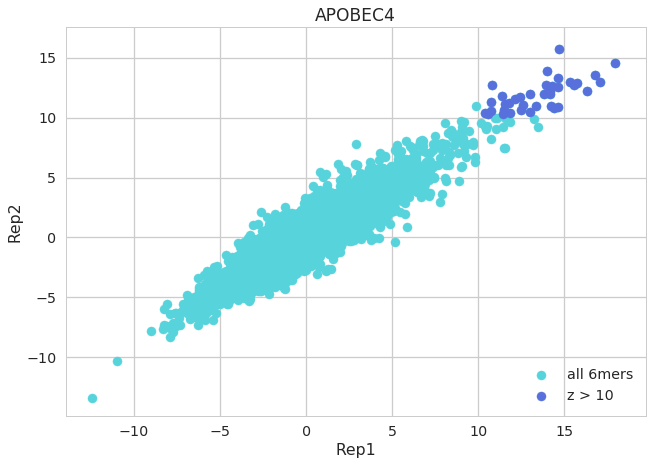

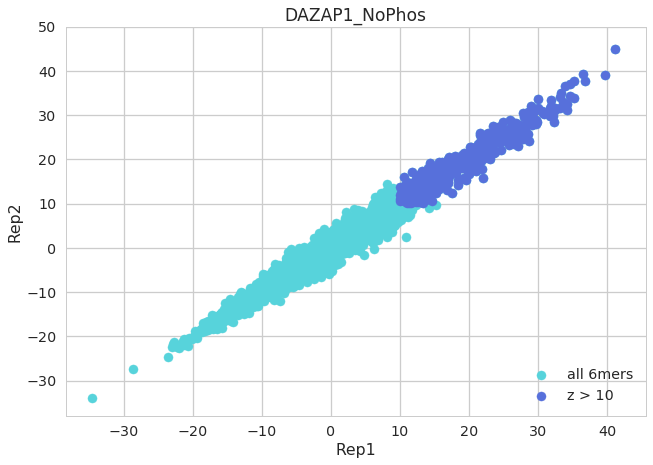

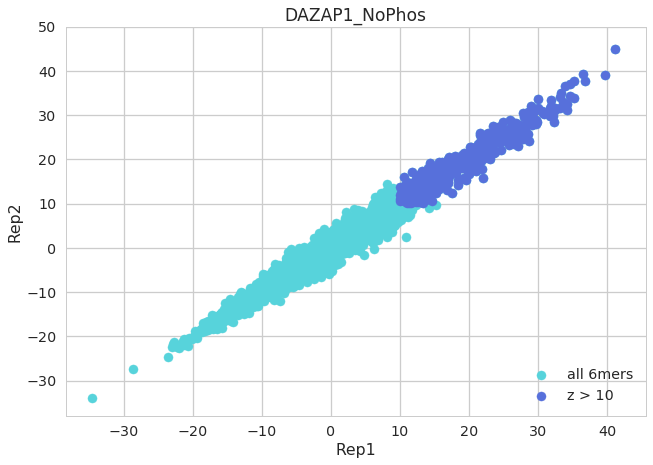

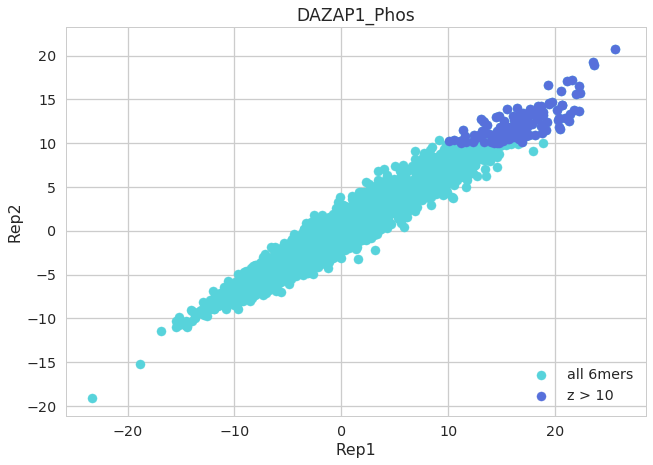

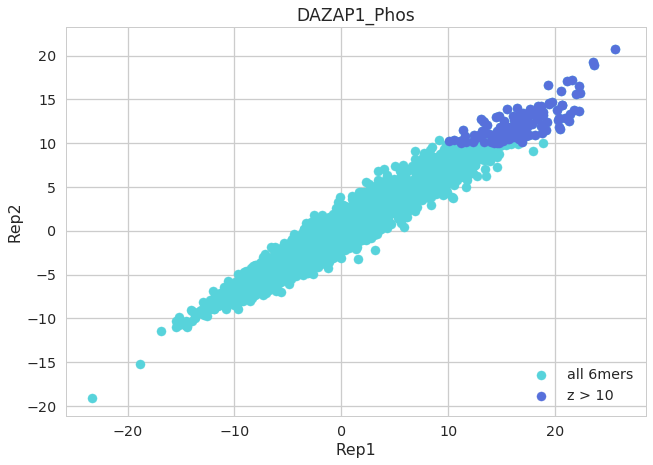

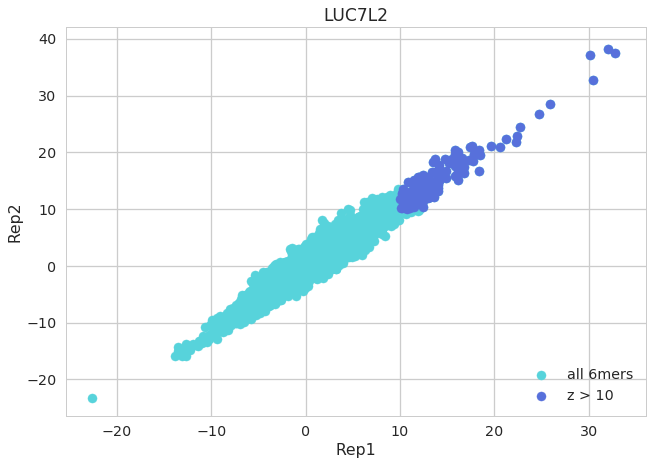

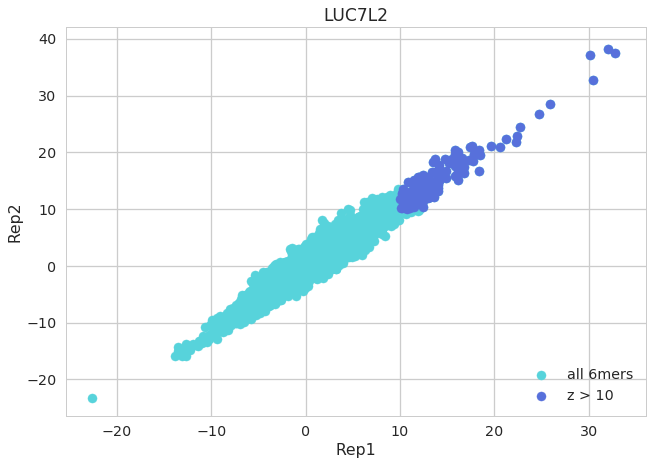

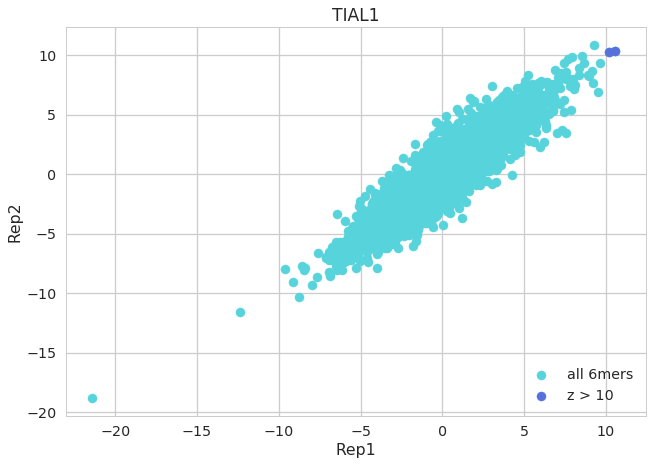

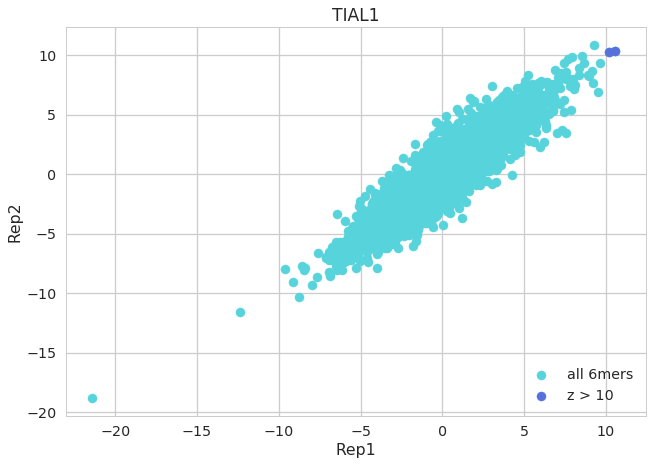

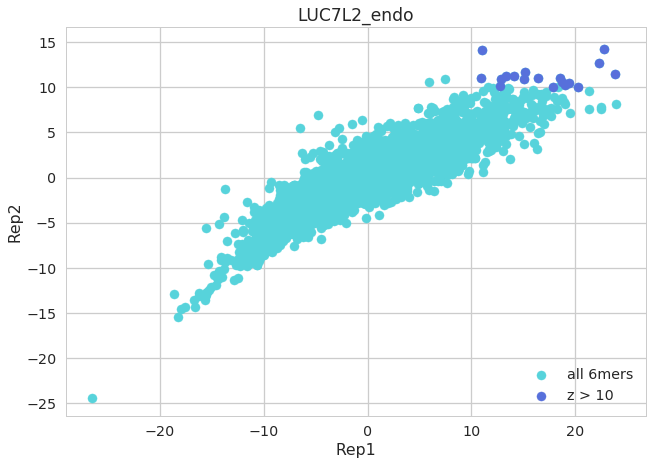

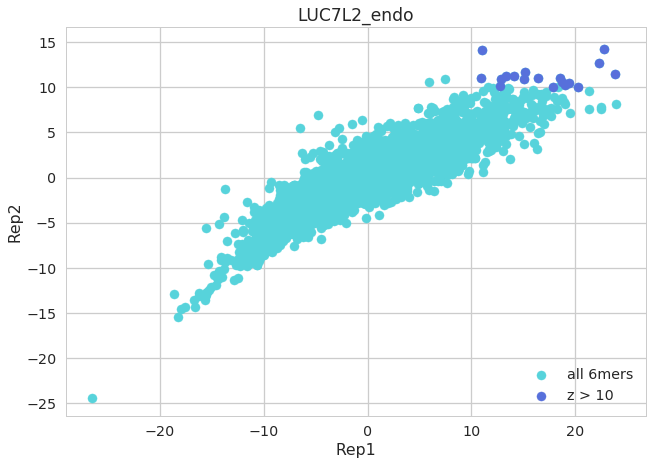

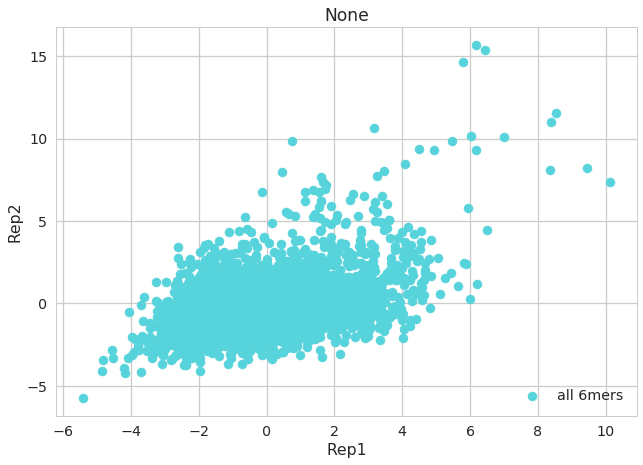

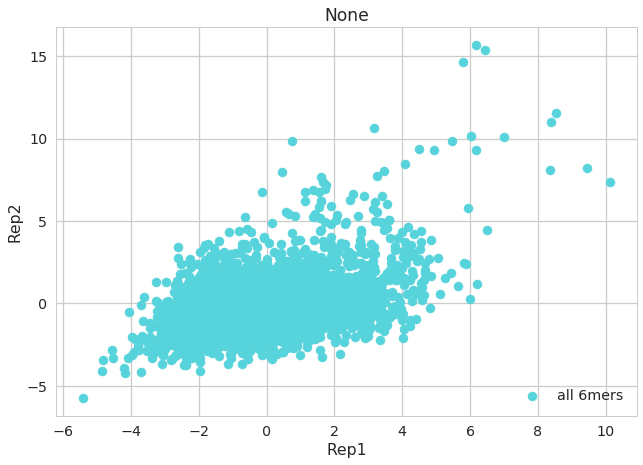

In [18]:
sigval = 10
# tbos's manifest uIDs are nicely formatted to do this:
def get_id_without_rep(row):
    """
    Returns the rep uID without the rep
    """
    return row['uID'].replace('_01','').replace('_02','')

manifest_df['ID'] = manifest_df.apply(get_id_without_rep,axis=1)

progress = tnrange(len(glob.glob(os.path.join(original_input_norm_dir,'*.annotated'))))


for ID in manifest_df['ID']:
    p = sorted(glob.glob(os.path.join(pickle_location, "{}_*.pickle".format(ID)))) # also only works if the only difference in uids is _01 and _02
    rbp_name = manifest_df[manifest_df['uID']==ID+'_01']['RBP'].to_string(index=False)
    if not len(p) == 2:
        print('only found one rep.')
    else:
        loaded1 = pickle.load(open(p[0],'rb'))
        loaded2 = pickle.load(open(p[1],'rb'))
        motif_scores1 = {}
        motif_scores2 = {}
        for key, value in loaded1['kmer_results']['all'][6].iteritems():
            motif_scores1[key] = value.delta
            motif_scores2[key] = loaded2['kmer_results']['all'][6][key].delta
        join1 = pd.DataFrame(motif_scores1,index=['rep1']).T
        join2 = pd.DataFrame(motif_scores2,index=['rep2']).T
        merged = pd.merge(join1, join2, how='left', left_index=True, right_index=True)
        f, ax = plt.subplots()
        ax.scatter(merged['rep1'],merged['rep2'],color=palette[4],label='all 6mers')
        significant = merged[(merged['rep1']> sigval) & (merged['rep2']> sigval)]
        img_file = os.path.join(img_dir,'{}_{}.inputnorm_peak_rep_zscores.svg'.format(ID,rbp_name))
        zscore_outfile = os.path.join(out_dir,'{}_{}.inputnorm_peak_rep_zscores.tsv'.format(ID,rbp_name))
        merged.to_csv(zscore_outfile,sep='\t')
        if not significant.shape[0] == 0:
            ax.scatter(significant['rep1'],significant['rep2'],color=palette[5],label='z > {}'.format(sigval))
            significant.to_csv(zscore_outfile.replace('.tsv','.enr{}.tsv'.format(sigval)),sep='\t')
        plt.legend(loc=4)
        ax.set_xlabel('Rep1')
        ax.set_ylabel('Rep2')
        ax.set_title(rbp_name)
        
        f.savefig(img_file)
        progress.update(1)

# APOBEC4 motif

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


('TAATGT', 14.703134304462051, 15.711466078281923)
('AAATGT', 14.651785670518308, 12.529228323086539)
('AATGTA', 13.026718560682557, 11.983324936116638)
('AATGTG', 12.41689972433714, 11.710863577801261)
('AATGTT', 14.622328679891037, 13.323698137468394)
('ATGTAT', 15.585681605871084, 12.689092983879725)


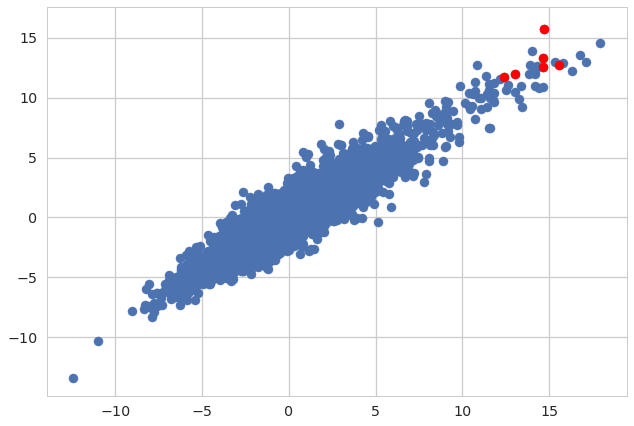

In [19]:
p1 = '/projects/ps-yeolab3/bay001/tbos/clip_analysis_output/APO_01_01.basedon_APO_01_01.peaks.l2inputnormnew.bed.compressed.p3.fc3.bed.clip_analysis.pickle'
p2 = '/projects/ps-yeolab3/bay001/tbos/clip_analysis_output/APO_02_01.basedon_APO_02_01.peaks.l2inputnormnew.bed.compressed.p3.fc3.bed.clip_analysis.pickle'
loaded1 = pickle.load(open(p1,'rb'))
loaded2 = pickle.load(open(p2,'rb'))
motif_scores1 = {}
motif_scores2 = {}
for key, value in loaded1['kmer_results']['all'][6].iteritems():
    motif_scores1[key] = value.delta
    motif_scores2[key] = loaded2['kmer_results']['all'][6][key].delta
join1 = pd.DataFrame(motif_scores1,index=['rep1']).T
join2 = pd.DataFrame(motif_scores2,index=['rep2']).T
merged = pd.merge(join1, join2, how='left', left_index=True, right_index=True)
moi = ['TAATGT','AAATGT','AATGTA','AATGTG','AATGTT','ATGTAT']
plt.scatter(merged['rep1'],merged['rep2'])
for m in moi:
    plt.scatter(merged['rep1'].ix[m], merged['rep2'].ix[m], color='red')
    print(m, merged['rep1'].ix[m], merged['rep2'].ix[m])

# Figure 5 - binding localization scatterplot

In [20]:
def get_skipped(row):
    """
    gets the region of the skipped exon.
    returns a list.
    """
    return [row['chrom'],str(row['exon_start']),str(row['exon_end']),row['event name'],'0',row['strand']]
def get_upstream(row):
    """
    gets the region upstream the skipped exon.
    returns a list.
    """
    if row['strand'] == '-':
        return [row['chrom'],str(row['exon_end']),str(row['exon_end']+500),row['event name'],'0',row['strand']]
    elif row['strand'] == '+':
        return [row['chrom'],str(row['exon_start']-500),str(row['exon_start']),row['event name'],'0',row['strand']]
    else:
        print("strand not correct")
        return -1
def get_downstream(row):
    """
    gets the region downstream the skipped exon.
    returns a list.
    """
    if row['strand'] == '+':
        return [row['chrom'],str(row['exon_end']),str(row['exon_end']+500),row['event name'],'0',row['strand']]
    elif row['strand'] == '-':
        return [row['chrom'],str(row['exon_start']-500),str(row['exon_start']),row['event name'],'0',row['strand']]
    else:
        print("strand not correct")
        return -1
    
# 
def filter_out_weird_chroms_and_unimportant_cols(df, event_cols, col_prefix='hta_sepscore_yeo_aug15_all_'):
    """
    From an output of an hta array, return sepscore and qvalue col for each sample,
    as well as the name of each condition present in the dataframe.
    
    This function was pulled from the splice array final analysis.
    """
    df = df[df['event position'].str.contains('chr[XY\d]+\:')==True] # remove noncanonical chromosomes (chr6_hap etc.)
    df = df[df['notes']!='complex '] # remove 'complex' events from the equation
    df['notes'] = df['notes'].replace(' ','') # removes that annoying extra space that is in the notes section.
    print("num events: ",df.shape[0])
    dfx = df.filter(regex=("^hta_sepscore"))
    conditions = [] # the conditions (apobec4_over, apobec4_kd, etc.)
    cols_to_keep = copy.copy(event_cols) # keep only the columns with the above prefix (grab all cols if col_prefix is none)

    for column in dfx.columns:
        if column.endswith("_sepscore"):
            if(column.startswith(col_prefix)):
                cols_to_keep.append(column)

        elif column.endswith("_q-value"):
            if(column.startswith(col_prefix)):
                cols_to_keep.append(column)
                conditions.append(
                    column.replace('_q-value','').replace('hta_sepscore_yeo_aug15_all_','')
                )
    df = df[cols_to_keep]
    return conditions, df


def build_sepscore_dict(conditions, df, col_prefix='hta_sepscore_yeo_aug15_all_'):
    """
    Given a set of conditions and the hta dataframe, return the significant 
    included/excluded/unchanged events as a dictionary
    
    Parameters
    ----------
    conditions : list 
        list of conditions
    df : dataframe
        table of events from the hta array
    col_prefix : string
        prefix that is common to all columns
        
    Returns
    -------
    scores : dict
        dictionary [condition] of dictionaries ['included', 'excluded', 'unchanged']
    """
    # Further separate by individual condition (apobec4_over, apobec4_kd, etc.)
    scores = {}
    y = tnrange(len(conditions))
    for condition in conditions:
        cols_to_keep = copy.copy(event_cols)
        sepscore_col = col_prefix + condition + '_sepscore'
        qvalue_col = col_prefix + condition + '_q-value'
        cols_to_keep.append(sepscore_col)
        cols_to_keep.append(qvalue_col)
        df[qvalue_col].fillna(1,inplace=True) # fill p-value nans with 1
        df[sepscore_col].fillna(0,inplace=True) # fill sepscore nans with 0

        included = df[
            (df[qvalue_col] < SPLICE_QVALUE_CUTOFF) & (df[sepscore_col] > SPLICE_SEPSCORE_CUTOFF)
        ]
        included = included[cols_to_keep]

        excluded = df[
            (df[qvalue_col] < SPLICE_QVALUE_CUTOFF) & (df[sepscore_col] < -SPLICE_SEPSCORE_CUTOFF)
        ]
        excluded = excluded[cols_to_keep]

        unchanged = df[
            (df[qvalue_col] < SPLICE_QVALUE_CUTOFF) & 
            (df[sepscore_col] >= -SPLICE_SEPSCORE_CUTOFF) & 
            (df[sepscore_col] <= SPLICE_SEPSCORE_CUTOFF)
        ]
        unchanged = unchanged[cols_to_keep]

        scores[condition] = {
            'included':included,
            'excluded':excluded,
            'unchanged':unchanged
        }
        y.update(1)
    return scores

In [21]:
event_cols = ['chrom','exon_start','exon_end','nice_name','0','strand','uniq_name','Gene','path','event position','event name','notes']

splice_data_df = pd.read_table(splice_data)
conditions, splice_data_df = filter_out_weird_chroms_and_unimportant_cols(splice_data_df, event_cols)
scores = build_sepscore_dict(conditions, splice_data_df)

('num events: ', 8046)


/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
def get_rbp_name_from_conditions(row):
    """
    Returns 'rbfox2' from "rbfox2_over" and "rbfox2_kd"
    """
    return row['conditions'].split('_')[0].upper()

def get_rbp_name_from_rbp_clip_name(row):
    """
    Returns 'RBFOX2' from "RBFOX2_01" and "RBFOX2_02"
    """
    return row['rbp'].split('_')[0]

def condition_to_column_name(row):
    """
    Turns a condition such as 'rbfox2_over' into its column-name form 
    (ie. hta_sepscore_yeo_aug15_all_rbfox2_over_sepscore)
    """
    return 'hta_sepscore_yeo_aug15_all_' + row['conditions'] + '_sepscore'

def index_to_inputnormed_bedfile(row):
    """
    Turns the uID into the canonical inputnormed bedfile format.
    """
    return '{}_01.basedon_{}_01.peaks.l2inputnormnew.bed.compressed.p3.fc3.sorted.bed'.format(
        row['index'], row['index']
    )


unused_list = ['rbfox2_kd6', 'trnau1ap_over2'] # we aren't using these conditions
acc2name_df = pd.DataFrame(acc2name,index=['rbp']).T # transform acc2name into a dataframe
conditions_df = pd.DataFrame(conditions,columns=['conditions']) # transform the hta array conditions into dataframe
conditions_df = conditions_df[conditions_df['conditions'].isin(unused_list)==False] # remove unused columns.
conditions_df['rbp_name_only'] = conditions_df.apply(get_rbp_name_from_conditions, axis=1) # get rbp name from conditions name
conditions_df['sepscore_column'] = conditions_df.apply(condition_to_column_name, axis=1) # re-format the rbp name into the actual column that exists in the sepscore file.
acc2name_df['rbp_name_only'] = acc2name_df.apply(get_rbp_name_from_rbp_clip_name, axis=1) # get rbp name from the acc2name dictionary
acc2name_df.reset_index(inplace=True) # reset index so that uID persists after the merge
acc2name_df['inputnorm_file'] = acc2name_df.apply(index_to_inputnormed_bedfile, axis=1) # get the peak file from the uID
merge_splice_and_clip_df = pd.merge(acc2name_df, conditions_df, how='left', on='rbp_name_only') # merge on RBP name
merge_splice_and_clip_df.dropna(inplace=True) # drop rbps where either clip or hta annotations dont exist
merge_splice_and_clip_df.reset_index(drop=True, inplace=True) # reset index to get final dataframe.

# Re-format the rbfox2 name from ENCODE to match Tbos' naming schema:
! ln -s $wd/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.p3.fc3.sorted.bed $wd/204_01_01.basedon_204_01_01.peaks.l2inputnormnew.bed.compressed.p3.fc3.sorted.bed
! ln -s $wd/204_02.basedon_204_02.peaks.l2inputnormnew.bed.compressed.p3.fc3.sorted.bed $wd/204_02_01.basedon_204_02_01.peaks.l2inputnormnew.bed.compressed.p3.fc3.sorted.bed

# Check to make sure the files exist where they're supposed to be:
for f in merge_splice_and_clip_df['inputnorm_file']:
    fexists = glob.glob(os.path.join(wd,f))
    if len(fexists) != 1:
        print('{} does not exist.'.format(f))
        
# Check to make sure the colums exist in the inclredo.csv file:

for column in merge_splice_and_clip_df['sepscore_column']:
    if column not in splice_data_df.columns:
        print("{} is not a column in splice_data_df".format(column))
        
merge_splice_and_clip_df.head(2)

ln: creating symbolic link `/projects/ps-yeolab3/bay001/tbos/input_norm/final_peaks//204_01_01.basedon_204_01_01.peaks.l2inputnormnew.bed.compressed.p3.fc3.sorted.bed': File exists
ln: creating symbolic link `/projects/ps-yeolab3/bay001/tbos/input_norm/final_peaks//204_02_01.basedon_204_02_01.peaks.l2inputnormnew.bed.compressed.p3.fc3.sorted.bed': File exists


index        rbp rbp_name_only  \
0  204_01  RBFOX2_01        RBFOX2   
1  204_01  RBFOX2_01        RBFOX2   

                                      inputnorm_file   conditions  \
0  204_01_01.basedon_204_01_01.peaks.l2inputnormn...  rbfox2_over   
1  204_01_01.basedon_204_01_01.peaks.l2inputnormn...   rbfox2_kd1   

                                   sepscore_column  
0  hta_sepscore_yeo_aug15_all_rbfox2_over_sepscore  
1   hta_sepscore_yeo_aug15_all_rbfox2_kd1_sepscore

In [23]:
def colstring(row,cols=[]):
    """
    returns a stringified column
    """
    st = ":"
    for col in cols:
        st = st + "{}:".format(row[col])
    return st
def remove_peaks(df1, df2, cols=[]):
    """
    returns df2 (lower priority) without df1 (higher priority) elements
    """
    df2['colstring'] = df2.apply(colstring,args=[cols],axis=1)
    df1['colstring'] = df1.apply(colstring,args=[cols],axis=1)
    dfx = df2[df2['colstring'].isin(df1['colstring'])==False]
    del dfx['colstring']
    return dfx


def get_fractions(label, clip, dfx, priority='ud', l10p = PVALUE_CUTOFF, l2fc = FOLD_CHANGE_CUTOFF):
    """
    Returns a dataframe of the number of overlaps between clip peaks and skipped exon regions.
    
    Parameters
    ----------
    clip : string
        filename of the input normed peaks
    dfx : dataframe
        table of sepscore events to overlap
    priority : string
        ud = prioritize upstream and downstream regions over exonic regions (default and used by tbos)
        all = double count peaks in both regions if a peak overlaps two regions
        exon = prioritize exon regions over upstream and downstream regions
    l10p : int
        p-value cutoff
    l2fc : int
        fold change cutoff
        
    Returns
    -------
    fractions : list
        [num_events, num_peaks, num_upstream_overlaps, num_exon_overlaps, num_downstream_overlaps]
    """
    bedhead = ['chrom','start','end','l10p','l2fc','strand']
    df = pd.read_table(clip, names=bedhead)
    clipdf = df[(df['l10p'] > l10p) & (df['l2fc'] > l2fc)]
    tool = pybedtools.BedTool.from_dataframe(clipdf).sort()
    
    upstreams = []
    skippeds = []
    downstreams = []
    
    """
    create list of upstream, skipped exon, and downstream regions
    """
    for col,row in dfx.iterrows():
        upstreams.append(pybedtools.create_interval_from_list(get_upstream(row)))
        skippeds.append(pybedtools.create_interval_from_list(get_skipped(row)))
        downstreams.append(pybedtools.create_interval_from_list(get_downstream(row)))

    upstreams = pybedtools.BedTool(upstreams).sort()
    skippeds = pybedtools.BedTool(skippeds).sort()
    downstreams = pybedtools.BedTool(downstreams).sort()
    
    """
    logic for counting peaks in all regions without regard to order or priority. 
    So, if a peak lies in both the skipped exon and in the downstream region,
    count +1 for each skipped and downstream.
    
    u: dataframe containing all upstream events with an overlapping peak
    s: dataframe containing all skipped events with an overlapping peak
    d: dataframe containing all downstream events with an overlapping peak
    
    logic for not potentially double counting events which 
    exist both in the exon region and within the up/downstream regions
    So, if a peak lies in both the skipped exon and in the downstream region,
    count +1 for the skipped region but not for the downstream/upstream region.

    """
    if(priority == 'all'):
        ux = upstreams.closest(tool,d=True,s=True,t='first').to_dataframe()
        sx = skippeds.closest(tool,d=True,s=True,t='first').to_dataframe()
        dx = downstreams.closest(tool,d=True,s=True,t='first').to_dataframe()
        ux = ux[ux[6]!='.']

        u = ux[ux[12]==0] # 14 if we're using compressed annotated... basically the column that describes the closest distance from the feature
        s = sx[sx[12]==0]
        d = dx[dx[12]==0]
    elif(priority == 'exon'):
        sx = skippeds.closest(tool,D='a',s=True,t='first').to_dataframe()
        u = sx[(sx[12]<0) & (sx[12]>=-500) & (sx[6]!='.')] # the . is for the -1's that may confound the numbers a bit.
        s = sx[sx[12]==0]
        d = sx[(sx[12]>0) & (sx[12]<=500)]
    else:
        # print('priority: up and downstream')
        ux = upstreams.closest(tool,d=True,s=True,t='first').to_dataframe()
        dx = downstreams.closest(tool,d=True,s=True,t='first').to_dataframe()
        sx = skippeds.closest(tool,d=True,s=True,t='first').to_dataframe()
        
        u = ux[ux[12]==0]
        d = dx[dx[12]==0]
        s = sx[sx[12]==0]
        if(s.shape[0] > 0 and u.shape[0] > 0):
            s = remove_peaks(u,s,[3,6,7,8,9,10,11])
        if(s.shape[0] > 0 and d.shape[0] > 0):
            s = remove_peaks(d,s,[3,6,7,8,9,10,11])
        
    sklen = 0
    count = 0
    for skipped in skippeds:
        sklen = sklen + len(skipped)
        count = count + 1
    
    avg_skipped_exon_len = sklen/float(count)
    return [len(upstreams), len(tool), u.shape[0], s.shape[0], d.shape[0]]

In [24]:
counts_included = {}
counts_excluded = {}
counts_unchanged = {}
rbps = []

progress = tnrange(merge_splice_and_clip_df.shape[0])

for col, row in merge_splice_and_clip_df.iterrows():
    
    clip = os.path.join(wd,row['inputnorm_file'])
    column = row['sepscore_column']
    condition = row['conditions']
    qval = column.replace(
        '_over_sepscore','_over_q-value').replace(
        '_kd_sepscore','_kd_q-value').replace(
        '_over1_sepscore','_over1_q-value')
    
    """
    df_included: if inc sepscore is > sep_score_threshold
    df_excluded: if inc sepscore is < -sep_score_threshold
    df_unchanged: if -sep_score_threshold >= inc sepscore >= sep_score_threshold
    
    """
    df_included = scores[condition]['included']
    
    df_excluded = scores[condition]['excluded']

    df_unchanged = scores[condition]['unchanged']
    
    label = column.replace('hta_sepscore_yeo_aug15_all_','').replace('_sepscore','')
    
    rbps.append(label)
    cliplabel = os.path.basename(clip)[:os.path.basename(clip).find('.basedon')]
    
    """
    save to a temp file to check later. These should be included/excluded events for each RBP.
    """
    df_included.to_csv(os.path.join(out_dir,'{}.included.df.csv'.format(label)),sep='\t')
    df_excluded.to_csv(os.path.join(out_dir,'{}.excluded.df.csv'.format(label)),sep='\t')
    df_unchanged.to_csv(os.path.join(out_dir,'{}.unchanged.df.csv'.format(label)),sep='\t')
    
    full_label = '{} - {}'.format(label,cliplabel)
    counts_included[full_label] = get_fractions('{} - {}'.format(label, 'included'), 
                                                clip, df_included)
    counts_excluded[full_label] = get_fractions('{} - {}'.format(label, 'excluded'), 
                                                clip, df_excluded)
    counts_unchanged[full_label] = get_fractions('{} - {}'.format(label, 'unchanged'), 
                                                 clip, df_unchanged)
    progress.update(1)
    
included = pd.DataFrame(counts_included).T
excluded = pd.DataFrame(counts_excluded).T
unchanged = pd.DataFrame(counts_unchanged).T

included.columns = ['num events', 'num peaks', 'upstream (500nt)','skipped','downstream (500nt)']
excluded.columns = ['num events', 'num peaks','upstream (500nt)','skipped','downstream (500nt)']
unchanged.columns = ['num events', 'num peaks','upstream (500nt)','skipped','downstream (500nt)']

included.index = included.index + ' - included'
excluded.index = excluded.index + ' - excluded'
unchanged.index = unchanged.index + ' - unchanged'

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/pybedtools/bedtool.py:3201: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [25]:
allfractions = pd.concat([included,excluded,unchanged])
allfractions.sort_index(inplace=True)
allfractions.head(2)

num events  num peaks  upstream (500nt)  \
apobec4_kd - APO_01_01 - excluded        1553       1940                16   
apobec4_kd - APO_01_01 - included         720       1940                 6   

                                   skipped  downstream (500nt)  
apobec4_kd - APO_01_01 - excluded        1                  21  
apobec4_kd - APO_01_01 - included        0                   8

In [26]:
df = allfractions.reset_index()

def rbp(row):
    """
    Returns the rbp name from the column string
    """
    return row['index'].split(' - ')[0]
def acc(row):
    """
    Returns the rbp accession uID from the column string
    """
    return row['index'].split(' - ')[1]
def cond(row):
    """
    Returns the rbp condition (included, excluded, unchanged) from the column string
    """
    return row['index'].split(' - ')[2]
df['rbp'] = df.apply(rbp,axis=1)
df['acc'] = df.apply(acc,axis=1)
df['cond'] = df.apply(cond,axis=1)
df.head()

index  num events  num peaks  \
0   apobec4_kd - APO_01_01 - excluded        1553       1940   
1   apobec4_kd - APO_01_01 - included         720       1940   
2  apobec4_kd - APO_01_01 - unchanged        1685       1940   
3   apobec4_kd - APO_02_01 - excluded        1553       1706   
4   apobec4_kd - APO_02_01 - included         720       1706   

   upstream (500nt)  skipped  downstream (500nt)         rbp        acc  \
0                16        1                  21  apobec4_kd  APO_01_01   
1                 6        0                   8  apobec4_kd  APO_01_01   
2                 8        0                   8  apobec4_kd  APO_01_01   
3                16        1                  16  apobec4_kd  APO_02_01   
4                 4        0                   9  apobec4_kd  APO_02_01   

        cond  
0   excluded  
1   included  
2  unchanged  
3   excluded  
4   included

In [27]:
# set up contingency table between included and unchanged:
up = [[0,0],[0,0]]
sk = [[0,0],[0,0]]
dn = [[0,0],[0,0]]

sigs = {}
for r in set(df['rbp']):
    for x in set(df['acc']):
        dfx = df[(df['rbp']==r) & (df['acc']==x)]
        if(dfx.shape[0] > 0):
            total_unchanged_events = int(dfx[dfx['cond']=='unchanged']['num events'])
            total_unchanged_events_with_peak_in_upstream = int(dfx[dfx['cond']=='unchanged']['upstream (500nt)'])
            total_unchanged_events_with_peak_in_skipped = int(dfx[dfx['cond']=='unchanged']['skipped'])
            total_unchanged_events_with_peak_in_downstream = int(dfx[dfx['cond']=='unchanged']['downstream (500nt)'])
            
            total_unchanged_events_no_peak_in_upstream = total_unchanged_events - total_unchanged_events_with_peak_in_upstream
            total_unchanged_events_no_peak_in_skipped = total_unchanged_events - total_unchanged_events_with_peak_in_skipped
            total_unchanged_events_no_peak_in_downstream = total_unchanged_events - total_unchanged_events_with_peak_in_downstream
            
            total_included_events = int(dfx[dfx['cond']=='included']['num events'])
            total_included_events_with_peak_in_upstream = int(dfx[dfx['cond']=='included']['upstream (500nt)'])
            total_included_events_with_peak_in_skipped = int(dfx[dfx['cond']=='included']['skipped'])
            total_included_events_with_peak_in_downstream = int(dfx[dfx['cond']=='included']['downstream (500nt)'])

            total_included_events_no_peak_in_upstream = total_included_events - total_included_events_with_peak_in_upstream
            total_included_events_no_peak_in_skipped = total_included_events - total_included_events_with_peak_in_skipped
            total_included_events_no_peak_in_downstream = total_included_events - total_included_events_with_peak_in_downstream
            
            total_excluded_events = int(dfx[dfx['cond']=='excluded']['num events'])
            total_excluded_events_with_peak_in_upstream = int(dfx[dfx['cond']=='excluded']['upstream (500nt)'])
            total_excluded_events_with_peak_in_skipped = int(dfx[dfx['cond']=='excluded']['skipped'])
            total_excluded_events_with_peak_in_downstream = int(dfx[dfx['cond']=='excluded']['downstream (500nt)'])

            total_excluded_events_no_peak_in_upstream = total_excluded_events - total_excluded_events_with_peak_in_upstream
            total_excluded_events_no_peak_in_skipped = total_excluded_events - total_excluded_events_with_peak_in_skipped
            total_excluded_events_no_peak_in_downstream = total_excluded_events - total_excluded_events_with_peak_in_downstream
            
            # build contingency table for included
            
            up[0][0] = total_included_events_with_peak_in_upstream
            up[0][1] = total_included_events_no_peak_in_upstream
            up[1][0] = total_unchanged_events_with_peak_in_upstream
            up[1][1] = total_unchanged_events_no_peak_in_upstream
            upsig = scipy.stats.fisher_exact(up)[1]
            
            sk[0][0] = total_included_events_with_peak_in_skipped
            sk[0][1] = total_included_events_no_peak_in_skipped
            sk[1][0] = total_unchanged_events_with_peak_in_skipped
            sk[1][1] = total_unchanged_events_no_peak_in_skipped
            sksig = scipy.stats.fisher_exact(sk)[1]
            
            dn[0][0] = total_included_events_with_peak_in_downstream
            dn[0][1] = total_included_events_no_peak_in_downstream
            dn[1][0] = total_unchanged_events_with_peak_in_downstream
            dn[1][1] = total_unchanged_events_no_peak_in_downstream
            dnsig = scipy.stats.fisher_exact(dn)[1]
            
            sigs["{} - {} - included".format(r,x)] = [upsig, sksig, dnsig]
            
            # build contingency table for excluded
            
            up[0][0] = total_excluded_events_with_peak_in_upstream
            up[0][1] = total_excluded_events_no_peak_in_upstream
            up[1][0] = total_unchanged_events_with_peak_in_upstream
            up[1][1] = total_unchanged_events_no_peak_in_upstream
            upsig = scipy.stats.fisher_exact(up)[1]
            
            sk[0][0] = total_excluded_events_with_peak_in_skipped
            sk[0][1] = total_excluded_events_no_peak_in_skipped
            sk[1][0] = total_unchanged_events_with_peak_in_skipped
            sk[1][1] = total_unchanged_events_no_peak_in_skipped
            sksig = scipy.stats.fisher_exact(sk)[1]
            
            dn[0][0] = total_excluded_events_with_peak_in_downstream
            dn[0][1] = total_excluded_events_no_peak_in_downstream
            dn[1][0] = total_unchanged_events_with_peak_in_downstream
            dn[1][1] = total_unchanged_events_no_peak_in_downstream
            dnsig = scipy.stats.fisher_exact(dn)[1]
            
            sigs["{} - {} - excluded".format(r,x)] = [upsig, sksig, dnsig]
dfx = pd.DataFrame(sigs).T

outfile = os.path.join(out_dir,'fisher_exact_pvalues.tsv')
dfx.to_csv(outfile,sep='\t')

In [28]:
dfx.columns = ['upstream (500nt)','skipped','downstream (500nt)']
dfx = -10*np.log10(dfx)
dfx = dfx.replace(0,0) # has a weird bug where -0 shows up instead of 0. 
outfile = os.path.join(out_dir,'fisher_exact_pvalues_-10log10.tsv')
dfx.to_csv(outfile,sep='\t')

In [29]:
def signage(df, rbp, acc, cond, col):
    """
    if FRACTION of bound exons is higher than unchanged, return +(1)
    else return -(1)
    """
    c1 = float(df[(df['rbp']==rbp) & (df['acc']==acc) & (df['cond']==cond)][col]) # number of events bound by cond (included or excluded)
    uc = float(df[(df['rbp']==rbp) & (df['acc']==acc) & (df['cond']=='unchanged')][col])
    c1events = float(df[(df['rbp']==rbp) & (df['acc']==acc) & (df['cond']==cond)]['num events']) # total events
    ucevents = float(df[(df['rbp']==rbp) & (df['acc']==acc) & (df['cond']=='unchanged')]['num events'])
    if c1/c1events > uc/ucevents:
        return 1
    else:
        return -1
    
signs = {}

for ix in df['index']:
    if 'unchanged' not in ix:
        row = df[df['index']==ix]
        rbp = row['rbp'].to_string(index=False)
        acc = row['acc'].to_string(index=False)
        cond = row['cond'].to_string(index=False)
        for col in ['upstream (500nt)', 'skipped', 'downstream (500nt)']:
            dfx.ix[ix][col] = dfx.ix[ix][col]*signage(df,rbp,acc,cond,col)
            
outfile = os.path.join(out_dir,'fisher_exact_pvalues_-10log10_signed.tsv')
dfx.to_csv(outfile, sep='\t')

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [30]:
def get_cond(row):
    return row['index'].split(' - ')[2]
def get_rep(row):
    return int(row['index'].split(' - ')[1].split('_')[-2])
def get_fullname(row):
    return row['index'].split(' - ')[0]
def get_oekd(row):
    return row['index'].split(' - ')[0].split('_')[1].replace(
        'over1','over').replace('over2','over').replace(
        'kd1','kd')
def get_rbp(row):
    return row['index'].split(' - ')[0].split('_')[0]
def get_samplename(row):
    return row['index'].split(' - ')[1]
def get_acc(row):
    return row['index'].split(' - ')[1].replace('_01','').replace('_02','')

df = dfx.reset_index()
df['cond'] = df.apply(get_cond,axis=1) # get condition (incl,excl)
df['rep'] = df.apply(get_rep,axis=1) # 
df['fullname'] = df.apply(get_fullname,axis=1)
df['expr'] = df.apply(get_oekd,axis=1)
df['rbp'] = df.apply(get_rbp,axis=1)
df['sample'] = df.apply(get_samplename,axis=1)
df['acc'] = df.apply(get_acc,axis=1)


df.tail()

index  upstream (500nt)   skipped  \
103     trnau1ap_kd - A9_02_01 - included          2.400270 -0.000000   
104  trnau1ap_over1 - A9_01_01 - excluded         -0.731190  5.730190   
105  trnau1ap_over1 - A9_01_01 - included          4.179263 -0.000000   
106  trnau1ap_over1 - A9_02_01 - excluded         -0.000000 -1.754916   
107  trnau1ap_over1 - A9_02_01 - included          9.494119 -0.000000   

     downstream (500nt)      cond  rep        fullname  expr       rbp  \
103            2.267044  included    2     trnau1ap_kd    kd  trnau1ap   
104            4.942215  excluded    1  trnau1ap_over1  over  trnau1ap   
105           14.226587  included    1  trnau1ap_over1  over  trnau1ap   
106           -0.000000  excluded    2  trnau1ap_over1  over  trnau1ap   
107            5.738710  included    2  trnau1ap_over1  over  trnau1ap   

       sample acc  
103  A9_02_01  A9  
104  A9_01_01  A9  
105  A9_01_01  A9  
106  A9_02_01  A9  
107  A9_02_01  A9

14


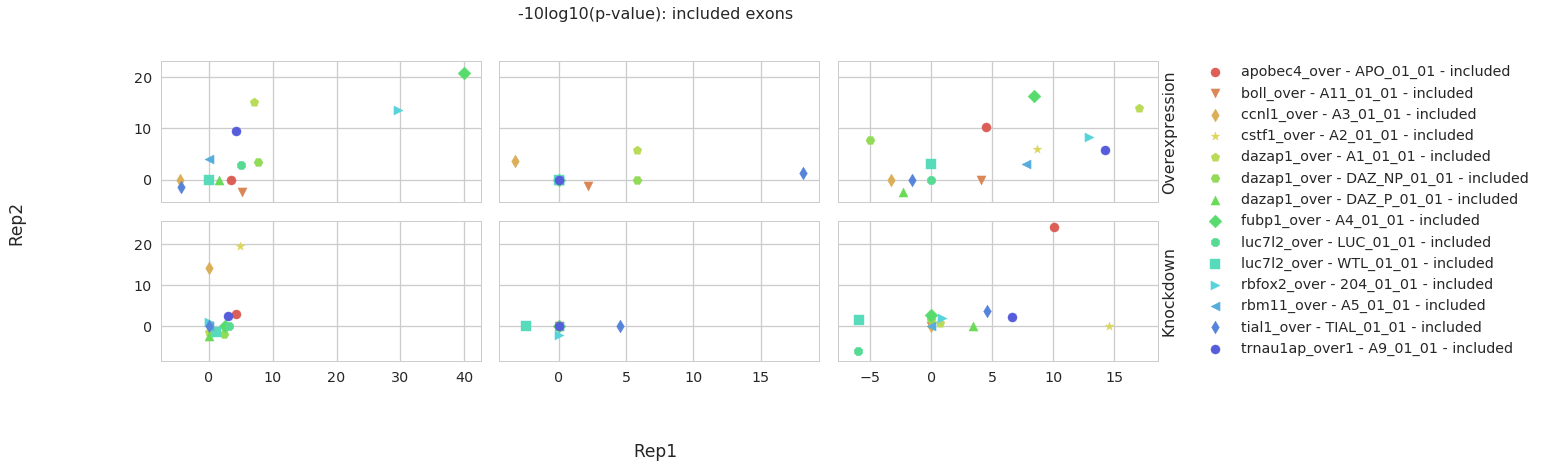

In [31]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,5))

condition = 'included'
colors = sns.color_palette("hls", 20)

"""
builds the top (overexpresion) plots
"""

dfx = df[(df['cond'] == condition) & (df['expr'] == 'over') & (df['rep']==1)] #.reset_index()
dfx.columns = dfx.columns + '_rep1'
dfy = df[(df['cond'] == condition) & (df['expr'] == 'over') & (df['rep']==2)] # .reset_index()
dfy.columns = dfy.columns + '_rep2'
# merged = pd.concat([dfx,dfy],axis=1)
merged1 = pd.merge(dfx,dfy,how='left',left_on=['cond_rep1','fullname_rep1','expr_rep1','acc_rep1'],
                                      right_on=['cond_rep2','fullname_rep2','expr_rep2','acc_rep2'])

"""
builds the bottom (knockdown) plots
"""
dfx = df[(df['cond'] == condition) & (df['expr'] == 'kd') & (df['rep']==1)] #.reset_index()
dfx.columns = dfx.columns + '_rep1'
dfy = df[(df['cond'] == condition) & (df['expr'] == 'kd') & (df['rep']==2)] # .reset_index()
dfy.columns = dfy.columns + '_rep2'
# merged = pd.concat([dfx,dfy],axis=1)
merged2 = pd.merge(dfx,dfy,how='left',left_on=['cond_rep1','fullname_rep1','expr_rep1','acc_rep1'],
                                      right_on=['cond_rep2','fullname_rep2','expr_rep2','acc_rep2'])

merged = pd.merge(merged1,merged2,how='outer',on=['rep_rep2','cond_rep2','rbp_rep2','sample_rep2','acc_rep2']).fillna(0)

marker = itertools.cycle(('o', 'v', 'd', '*', 'p',
                          'H','^','D','8','s','>',
                          '<','d')) 
print(merged.shape[0])
for i in range(0,(merged.shape[0])):
    c = i
    m = marker.next()
    ax1.scatter(merged.iloc[i]['upstream (500nt)_rep1_x'],merged.iloc[i]['upstream (500nt)_rep2_x'],label=merged.iloc[i]['index_rep1_x'],color=colors[c],marker=m)
    ax2.scatter(merged.iloc[i]['skipped_rep1_x'],merged.iloc[i]['skipped_rep2_x'],label=merged.iloc[i]['index_rep1_x'],color=colors[c],marker=m)
    ax3.scatter(merged.iloc[i]['downstream (500nt)_rep1_x'],merged.iloc[i]['downstream (500nt)_rep2_x'],label=merged.iloc[i]['index_rep1_x'],color=colors[c],marker=m)
    ax3.set_ylabel('Overexpression')
    ax3.yaxis.set_label_position("right")
    ax4.scatter(merged.iloc[i]['upstream (500nt)_rep1_y'],merged.iloc[i]['upstream (500nt)_rep2_y'],label=merged.iloc[i]['index_rep1_x'],color=colors[c],marker=m)
    ax5.scatter(merged.iloc[i]['skipped_rep1_y'],merged.iloc[i]['skipped_rep2_y'],label=merged.iloc[i]['index_rep1_x'],color=colors[c],marker=m)
    ax6.scatter(merged.iloc[i]['downstream (500nt)_rep1_y'],merged.iloc[i]['downstream (500nt)_rep2_y'],label=merged.iloc[i]['index_rep1_x'],color=colors[c],marker=m)
    ax6.set_ylabel('Knockdown')
    ax6.yaxis.set_label_position("right")
    plt.legend(bbox_to_anchor=(3.4, 2.4))
f.text(0.5, -0.15, 'Rep1', ha='center')
f.text(-0.10, 0.5, 'Rep2', va='center', rotation='vertical')
plt.suptitle('-10log10(p-value): {} exons'.format(condition),fontsize=16,y=1.1)
plt.legend(bbox_to_anchor=(2.2, 2.2))
plt.tight_layout()
plt.savefig(
    os.path.join(
        img_dir, 'scatter-{}.svg'.format(condition)
    ),
    bbox_inches='tight'
)

# Make the rbp-maps

In [32]:
manifest_df.ix[0]['ip']

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


'/projects/ps-yeolab3/bay001/tbos/input_norm/final_peaks/A11_01_BOLL_ReadsByLoc_combined.csv.l2fcwithpval_enr.csv'

In [33]:
rbps = ['CCNL1', 'LUC7L2', 'CSTF1','TRNAU1AP','RBM11','FUBP1']

norm_schema = normalization_functions.normalize_and_per_region_subtract
# norm_schema = normalization_functions.get_density

rbp_progress = tnrange(len(rbps))
for rbp in rbps:
    f, (ax1, ax2, ax3, ax4) = plt.subplots(
    1, 4, sharey=True, figsize=(16,8)
    )
    axs = [ax1, ax2, ax3, ax4]
    manifest_progress = tnrange(manifest_df[manifest_df['RBP']==rbp].shape[0])
    for col, row in manifest_df[manifest_df['RBP']==rbp].iterrows():
        output_file = os.path.join(wd,"{}-{}.svg".format(rbp, row['uID']))
        pos_ip_bw = row['CLIP'].replace('.bam','.norm.neg.bw')
        neg_ip_bw = row['CLIP'].replace('.bam','.norm.pos.bw')
        pos_in_bw = row['INPUT'].replace('.bam','.norm.neg.bw')
        neg_in_bw = row['INPUT'].replace('.bam','.norm.pos.bw')
        ip_bam = row['CLIP']
        inp_bam = row['INPUT']
        included = glob.glob(miso_directory + "{}_over*included*.tsv".format(rbp.lower()))[0]
        excluded = glob.glob(miso_directory + "{}_over*excluded*.tsv".format(rbp.lower()))[0]
        unchanged = glob.glob(miso_directory + "{}_over*unchanged*.tsv".format(rbp.lower()))[0]
        annotations = {included:'miso', excluded:'miso', unchanged:'miso'}
        
        ip_rd = ReadDensity.ReadDensity(pos=pos_ip_bw,neg=neg_ip_bw,bam=ip_bam)
        in_rd = ReadDensity.ReadDensity(pos=pos_in_bw,neg=neg_in_bw,bam=inp_bam)
        rbpmap = Map.SkippedExon(
            ip=ip_rd, inp=in_rd, output_filename=output_file,
            norm_function=norm_schema,
            annotation=annotations,intron_offset=400,
        )
        rbpmap.create_matrices()
        print('creating matrices DONE')
        rbpmap.normalize_matrix()
        print('normalizing DONE')
        rbpmap.set_means_and_sems()
        print('setting mean and sems DONE')
        RDPlotter.plot_se(rbpmap.means, rbpmap.sems, axs)
        manifest_progress.update(1)
    plt.tight_layout(pad=8, w_pad=3, h_pad=5)
    f.suptitle(rbp)
    f.savefig(os.path.join(img_dir,'{}.rbpmap.normed.svg'.format(rbp)))
    plt.clf()
    plt.cla()
    plt.close()
    rbp_progress.update(1)

creating matrices DONE
normalizing DONE
setting mean and sems DONE
creating matrices DONE
normalizing DONE
setting mean and sems DONE


creating matrices DONE
normalizing DONE
setting mean and sems DONE
creating matrices DONE
normalizing DONE
setting mean and sems DONE


creating matrices DONE
normalizing DONE
setting mean and sems DONE
creating matrices DONE
normalizing DONE
setting mean and sems DONE


creating matrices DONE
normalizing DONE
setting mean and sems DONE
creating matrices DONE
normalizing DONE
setting mean and sems DONE


creating matrices DONE
normalizing DONE
setting mean and sems DONE
creating matrices DONE
normalizing DONE
setting mean and sems DONE


creating matrices DONE
normalizing DONE
setting mean and sems DONE
creating matrices DONE
normalizing DONE
setting mean and sems DONE


In [34]:
rbps = ['CCNL1', 'LUC7L2', 'CSTF1','TRNAU1AP','RBM11','FUBP1']

# norm_schema = normalization_functions.normalize_and_per_region_subtract
norm_schema = normalization_functions.read_entropy

rbp_progress = tnrange(len(rbps))
for rbp in rbps:
    f, (ax1, ax2, ax3, ax4) = plt.subplots(
        1, 4, sharey=True, figsize=(16,8)
    )
    axs = [ax1, ax2, ax3, ax4]
    manifest_progress = tnrange(manifest_df[manifest_df['RBP']==rbp].shape[0])
    for col, row in manifest_df[manifest_df['RBP']==rbp].iterrows():
        
        output_file = os.path.join(wd,"{}-{}.svg".format(rbp, row['uID']))
        pos_ip_bw = row['CLIP'].replace('.bam','.norm.neg.bw')
        neg_ip_bw = row['CLIP'].replace('.bam','.norm.pos.bw')
        pos_in_bw = row['INPUT'].replace('.bam','.norm.neg.bw')
        neg_in_bw = row['INPUT'].replace('.bam','.norm.pos.bw')
        ip_bam = row['CLIP']
        inp_bam = row['INPUT']
        included = glob.glob(miso_directory + "{}_over*included*.tsv".format(rbp.lower()))[0]
        excluded = glob.glob(miso_directory + "{}_over*excluded*.tsv".format(rbp.lower()))[0]
        unchanged = glob.glob(miso_directory + "{}_over*unchanged*.tsv".format(rbp.lower()))[0]
        annotations = {included:'miso', excluded:'miso', unchanged:'miso'}
        print(unchanged)
        ip_rd = ReadDensity.ReadDensity(pos=pos_ip_bw,neg=neg_ip_bw,bam=ip_bam)
        in_rd = ReadDensity.ReadDensity(pos=pos_in_bw,neg=neg_in_bw,bam=inp_bam)
        rbpmap = Map.SkippedExon(
            ip=ip_rd, inp=in_rd, output_filename=output_file,
            norm_function=norm_schema,
            annotation=annotations,intron_offset=400,
        )
        rbpmap.create_matrices()
        print('creating matrices DONE')
        rbpmap.normalize_matrix()
        print('normalizing DONE')
        rbpmap.set_means_and_sems()
        print('setting mean and sems DONE')
        RDPlotter.plot_se(rbpmap.means, rbpmap.sems, axs)
        manifest_progress.update(1)
    plt.tight_layout(pad=8, w_pad=3, h_pad=5)
    f.suptitle(rbp)
    f.savefig(os.path.join(img_dir,'{}.rbpmap.entropy.svg'.format(rbp)))
    plt.clf()
    plt.cla()
    plt.close()
    rbp_progress.update(1)

/home/bay001/projects/tbos_splicing_20160203/data/temp/3-10-2017/ccnl1_over.unchanged.sep_0.5.p_0.05.tsv
creating matrices DONE
normalizing DONE
setting mean and sems DONE
/home/bay001/projects/tbos_splicing_20160203/data/temp/3-10-2017/ccnl1_over.unchanged.sep_0.5.p_0.05.tsv
creating matrices DONE
normalizing DONE
setting mean and sems DONE


/home/bay001/projects/tbos_splicing_20160203/data/temp/3-10-2017/luc7l2_over.unchanged.sep_0.5.p_0.05.tsv
creating matrices DONE
normalizing DONE
setting mean and sems DONE
/home/bay001/projects/tbos_splicing_20160203/data/temp/3-10-2017/luc7l2_over.unchanged.sep_0.5.p_0.05.tsv
creating matrices DONE
normalizing DONE
setting mean and sems DONE


/home/bay001/projects/tbos_splicing_20160203/data/temp/3-10-2017/cstf1_over.unchanged.sep_0.5.p_0.05.tsv
creating matrices DONE
normalizing DONE
setting mean and sems DONE
/home/bay001/projects/tbos_splicing_20160203/data/temp/3-10-2017/cstf1_over.unchanged.sep_0.5.p_0.05.tsv
creating matrices DONE
normalizing DONE
setting mean and sems DONE


/home/bay001/projects/tbos_splicing_20160203/data/temp/3-10-2017/trnau1ap_over2.unchanged.sep_0.5.p_0.05.tsv
creating matrices DONE
normalizing DONE
setting mean and sems DONE
/home/bay001/projects/tbos_splicing_20160203/data/temp/3-10-2017/trnau1ap_over2.unchanged.sep_0.5.p_0.05.tsv
creating matrices DONE
normalizing DONE
setting mean and sems DONE


/home/bay001/projects/tbos_splicing_20160203/data/temp/3-10-2017/rbm11_over.unchanged.sep_0.5.p_0.05.tsv
creating matrices DONE
normalizing DONE
setting mean and sems DONE
/home/bay001/projects/tbos_splicing_20160203/data/temp/3-10-2017/rbm11_over.unchanged.sep_0.5.p_0.05.tsv
creating matrices DONE
normalizing DONE
setting mean and sems DONE


/home/bay001/projects/tbos_splicing_20160203/data/temp/3-10-2017/fubp1_over.unchanged.sep_0.5.p_0.05.tsv
creating matrices DONE
normalizing DONE
setting mean and sems DONE
/home/bay001/projects/tbos_splicing_20160203/data/temp/3-10-2017/fubp1_over.unchanged.sep_0.5.p_0.05.tsv
creating matrices DONE
normalizing DONE
setting mean and sems DONE


# Fixes: Make venn diagram reflect the numbers

In [35]:
%matplotlib inline
from matplotlib_venn import venn3

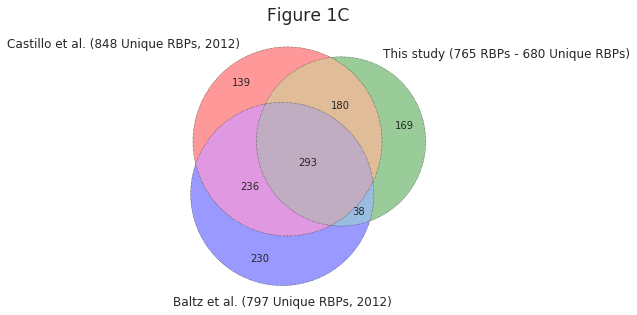

In [36]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib_venn import venn3, venn3_circles

plt.figure(figsize=(5,5))
v = venn3(subsets=(139, 169, 180, 230, 236, 38, 293), set_labels = ('A', 'B', 'C'))

# v.get_label_by_id('100').set_text('Unknown')
v.get_label_by_id('A').set_text('Castillo et al. (848 Unique RBPs, 2012)')
v.get_label_by_id('B').set_text('This study (765 RBPs - 680 Unique RBPs)')
v.get_label_by_id('C').set_text('Baltz et al. (797 Unique RBPs, 2012)')

c = venn3_circles(subsets=(139, 169, 180, 230, 236, 38, 293), linewidth=0.5, linestyle='dotted')
# c[0].set_lw(1.0)
# c[0].set_ls('dotted')
plt.title("Figure 1C")
plt.tight_layout(pad=3)
# plt.show()
plt.savefig('/projects/ps-yeolab3/bay001/tbos/images/venn-diagram-rbps-figure1c.svg')

# Create new heatmap

In [38]:
readsByLoc_files = glob.glob('/projects/ps-yeolab3/bay001/tbos/input_norm/input_norm_latest/*ReadsByLoc_combined.csv')
print(len(readsByLoc_files))
readsByLoc_files[:3] # make sure we're grabbing the right ones

30


['/projects/ps-yeolab3/bay001/tbos/input_norm/input_norm_latest/LUC_01_LUC7L2_ReadsByLoc_combined.csv',
 '/projects/ps-yeolab3/bay001/tbos/input_norm/input_norm_latest/A1_02_DAZAP1_ReadsByLoc_combined.csv',
 '/projects/ps-yeolab3/bay001/tbos/input_norm/input_norm_latest/WTV5_02_None_ReadsByLoc_combined.csv']

In [39]:
def get_sum(df, lbl):
    df.set_index('ENSG', inplace=True)
    df_sum = pd.DataFrame(df.sum(axis=1))
    df_sum = df_sum + 1
    df_sum.columns = [lbl]
    return df_sum

df = pd.read_table(readsByLoc_files[0], index_col=0)
merged = pd.DataFrame(index=df.index)

progress = tnrange(len(readsByLoc_files))

for readsByLoc in readsByLoc_files:
    df = pd.read_table(readsByLoc).fillna(0)
    del df['Unnamed: 17'] # remove the extra column produced by an abberrant tab
    df.columns = [
        'ENSG',
        'ip_cds','ip_5utr','ip_3utr','ip_53utr','ip_intron','ip_intergenic','ip_nc_exon','ip_nc_intron',
        'inp_cds','inp_5utr','inp_3utr','inp_53utr','inp_intron','inp_intergenic','inp_nc_exon','inp_nc_intron'
    ]
    assert df[df['inp_intergenic']!=0].shape[0] == 0 # don't know why there would be intergenic reads... 
    assert df[df['ip_intergenic']!=0].shape[0] == 0
    ip_reads = df[['ENSG','ip_cds','ip_5utr','ip_3utr','ip_53utr','ip_intron','ip_intergenic','ip_nc_exon','ip_nc_intron']]
    inp_reads = df[['ENSG','inp_cds','inp_5utr','inp_3utr','inp_53utr','inp_intron','inp_intergenic','inp_nc_exon','inp_nc_intron']]
    ip_sum = get_sum(ip_reads,'ip')
    inp_sum = get_sum(inp_reads,'inp')
    l2fc = pd.DataFrame(np.log2(ip_sum['ip'].div(inp_sum['inp'])))
    l2fc.columns = [os.path.basename(readsByLoc).replace('_ReadsByLoc_combined.csv','')]
    merged = pd.merge(merged, l2fc, how='outer', left_index=True, right_index=True)
    progress.update(1)
merged = merged.fillna(0)
merged.columns

Index([u'LUC_01_LUC7L2', u'A1_02_DAZAP1', u'WTV5_02_None', u'A5_02_RBM11',
       u'A11_01_BOLL', u'WTL_01_LUC7L2_endo', u'APO_01_APOBEC4',
       u'A11_02_BOLL', u'A9_02_TRNAU1AP', u'A6_01_LUC7L',
       u'DAZ_P_02_DAZAP1_Phos', u'A3_01_CCNL1', u'APO_02_APOBEC4',
       u'TIAL_02_TIAL1', u'A4_01_FUBP1', u'WTV5_01_None', u'A2_01_CSTF1',
       u'A6_02_LUC7L', u'LUC_02_LUC7L2', u'A1_01_DAZAP1', u'A3_02_CCNL1',
       u'A4_02_FUBP1', u'TIAL_01_TIAL1', u'A2_02_CSTF1',
       u'DAZ_NP_02_DAZAP1_NoPhos', u'A5_01_RBM11', u'WTL_02_LUC7L2_endo',
       u'DAZ_NP_01_DAZAP1_NoPhos', u'A9_01_TRNAU1AP', u'DAZ_P_01_DAZAP1_Phos'],
      dtype='object')

In [40]:
del merged['WTV5_01_None']
del merged['WTV5_02_None']
del merged['DAZ_P_01_DAZAP1_Phos']
del merged['DAZ_P_02_DAZAP1_Phos']
del merged['DAZ_NP_01_DAZAP1_NoPhos']
del merged['DAZ_NP_02_DAZAP1_NoPhos']

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


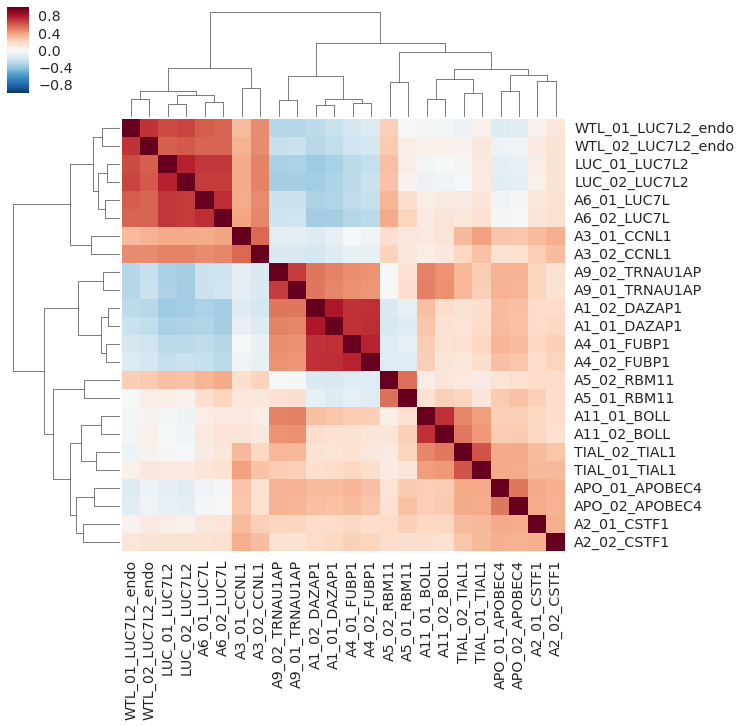

In [41]:
cg = sns.clustermap(merged.corr())
set_labels = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

merged.corr().to_csv('/projects/ps-yeolab3/bay001/tbos/images/heatmap_l2fc_readcounts_correlation.txt',sep='\t')
cg.savefig('/projects/ps-yeolab3/bay001/tbos/images/heatmap_l2fc_readcounts_correlation.svg')